# Team Nova DataFest22's Datathon ML Submission

Help a Financial Industry predict who is likely to complete an E-process application

## Project Overview

### Background

**BorrowMe** is a peer-to-peer lending and renting platform that connects individuals who own underused items with people who need them temporarily. The platform benefits everyone involved. Lenders make money, borrowers save money, and the Earth's toxic load is reduced—one platform to help them all.

My team just got hired as a Data Science team at Borrowme, a fintech playing in the lending space. The CEO tasks us with helping to revamp the lending process due to complaints from customers on the time the process takes

### Project Task

The IT team has provided historical information containing the information of applicants and the status of their loan application process. You are expected to automate the process by building a machine learning model to predict the outcome of the lending process if the credit facility process was completed via e-process, that is E-Signed or not.

### Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lightgbm import LGBMClassifier
import optuna
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)


### Data Gathering

The datasets provided for this project are imported using pandas and loaded into a dataframe

In [2]:
# to read the train.csv dataset into a dataframe 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# to see the overview of the table
train.head()

Entry_id  age  pay_schedule  home_owner  income  months_employed  \
0   7629673   40     bi-weekly           1    3135                0   
1   5335819   33  semi-monthly           0    3590                0   
2   8492423   21        weekly           0    2303                0   
3   7948313   26     bi-weekly           0    2795                0   
4   4297036   43     bi-weekly           0    5000                0   

   years_employed  current_address_year  personal_account_m  \
0               3                     3                   6   
1               5                     2                   2   
2               5                     8                   2   
3               4                     4                   1   
4               2                     1                   1   

   personal_account_y  has_debt  amount_requested  risk_score  risk_score_2  \
0                   2         1               550       36200      0.737398   
1                   8         1              1100       53850      0.617361   
2                   7         1               600       74850      0.677109   
3                   6         1               800       50800      0.738055   
4                   2         1              1100       69100      0.798303   

   risk_score_3  risk_score_4  risk_score_5  ext_quality_score  \
0      0.903517      0.487712      0.515977           0.580918   
1      0.857560      0.613487      0.665523           0.744634   
2      0.758765      0.495609      0.664762           0.592556   
3      0.873204      0.666437      0.700392           0.584130   
4      0.841747      0.401971      0.568787           0.525905   

   ext_quality_score_2  inquiries_last_month  e_signed  
0             0.380918                    10         1  
1             0.744634                    12         0  
2             0.492556                     6         1  
3             0.684130                    14         1  
4             0.725905                     5         1

#### Columns
- Entry_id : User Identifier - client
- age: Age of user
- pay_schedule: How often applicants get paid
- home_owner: 0:- Rented home 1:- Owner
- income: Applicant income
- months_employed: How many months has he been doing the job
- years_employed: How many years he been doing job
- current_address_year: How many years a person stayed at the current address
- personal_account_m: How many months that person had a personal account
- personal_account_y: How many years has that person had a personal account
- has_debt: If the individual has debt
- amount_requested: Loan amount requested
- risk_score_n (1,2,3,4,5):- Various scores are defined by regulations and internal processes to classify individual risks
- ext_quality_score_n (1 & 2): External quality scores defined for each individual
- inquiries_last_month: Number of times an individual made inquiries in the previous month.
- e_signed: If the application was completed as an e-signing process or not

### Data Assessing and Cleaning

In this section, the dataset is assessed for Quality and Tidiness issues and cleaned to obtain a clean data

In [3]:
# to get the info of the table
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entry_id              12516 non-null  int64  
 1   age                   12516 non-null  int64  
 2   pay_schedule          12516 non-null  object 
 3   home_owner            12516 non-null  int64  
 4   income                12516 non-null  int64  
 5   months_employed       12516 non-null  int64  
 6   years_employed        12516 non-null  int64  
 7   current_address_year  12516 non-null  int64  
 8   personal_account_m    12516 non-null  int64  
 9   personal_account_y    12516 non-null  int64  
 10  has_debt              12516 non-null  int64  
 11  amount_requested      12516 non-null  int64  
 12  risk_score            12516 non-null  int64  
 13  risk_score_2          12516 non-null  float64
 14  risk_score_3          12516 non-null  float64
 15  risk_score_4       

In [4]:
# to get the shape of the table
train.shape

(12516, 21)

From the above result, There are 12,516 rows and 21 columns

In [5]:
# to check for the presence of null values
train.isnull().sum()

Entry_id                0
age                     0
pay_schedule            0
home_owner              0
income                  0
months_employed         0
years_employed          0
current_address_year    0
personal_account_m      0
personal_account_y      0
has_debt                0
amount_requested        0
risk_score              0
risk_score_2            0
risk_score_3            0
risk_score_4            0
risk_score_5            0
ext_quality_score       0
ext_quality_score_2     0
inquiries_last_month    0
e_signed                0
dtype: int64

From the above analysis, there are no null values presence in the train table.

In [6]:
# to check for duplicate rows
sum(train.duplicated())

0

There are no duplicate records in the train data. To check if there are duplicate records in the `entry_id` column

In [7]:
# to check for duplicated records in the entry_id column
train['Entry_id'].duplicated().sum()

6

There have been 6 observed duplicates in the "Entry_id" column. Further investigation would be done

In [8]:
# to print out the rows where the ID is in the IDs of duplicated rows
ids = train['Entry_id']
duplicate_id = ids[ids.duplicated()]
train[ids.isin(duplicate_id)].sort_values('Entry_id')

Entry_id  age  pay_schedule  home_owner  income  months_employed  \
2488    3903643   41     bi-weekly           0    3035                0   
9804    3903643   38     bi-weekly           1    2620                0   
7213    5659209   42     bi-weekly           1    2140                0   
7288    5659209   46     bi-weekly           1    7092                0   
5361    5896278   31        weekly           0    1635                0   
11829   5896278   30     bi-weekly           0    3795                0   
4419    5946902   43  semi-monthly           1    4725                3   
12124   5946902   41  semi-monthly           1    4295                2   
2626    7450902   57     bi-weekly           0    5295                0   
9209    7450902   35     bi-weekly           0    4095                6   
1487    8156839   37     bi-weekly           0    3020                0   
11067   8156839   48     bi-weekly           0    3205                0   

       years_employed  current_address_year  personal_account_m  \
2488                5                     0                   2   
9804                2                     0                   6   
7213                2                     9                   6   
7288                3                     1                   2   
5361                6                     5                   2   
11829               2                     3                   1   
4419                6                     6                   5   
12124               2                     1                   3   
2626                6                     4                   2   
9209                2                     0                   1   
1487                1                     7                   4   
11067               2                     0                   5   

       personal_account_y  has_debt  amount_requested  risk_score  \
2488                    6         0               700       56550   
9804                    4         1               400       67050   
7213                    4         1               400       56700   
7288                    3         0               700       64350   
5361                    2         1               400       73200   
11829                   3         1               800       50650   
4419                    8         1              1000       59250   
12124                   2         1              1200       54100   
2626                    6         1              1700       91500   
9209                    3         0               700       57850   
1487                    4         1               600       53550   
11067                   3         1               500       53650   

       risk_score_2  risk_score_3  risk_score_4  risk_score_5  \
2488       0.574753      0.843991      0.241663      0.516921   
9804       0.740419      0.939486      0.684477      0.778170   
7213       0.781691      0.920329      0.481009      0.594963   
7288       0.679462      0.757643      0.550134      0.391500   
5361       0.797840      0.849569      0.687969      0.741433   
11829      0.760728      0.850893      0.573459      0.606560   
4419       0.724398      0.944054      0.444145      0.582691   
12124      0.681107      0.860848      0.525299      0.689527   
2626       0.648824      0.789179      0.640210      0.653759   
9209       0.780735      0.929274      0.625784      0.792078   
1487       0.728198      0.881015      0.647649      0.742549   
11067      0.623579      0.801490      0.621682      0.654174   

       ext_quality_score  ext_quality_score_2  inquiries_last_month  e_signed  
2488            0.715925             0.715925                    15         1  
9804            0.629805             0.729805                     9         1  
7213            0.736846             0.536846                     6         1  
7288            0.487792             0.587792                     6         1  
5361           

The rows with duplicate "Entry_id" were observed and we noticed that thier fields were different so We decided not to drop these rows and thier values might influence our analysis.

.

In [9]:
# to check for the percentage of unique records
train.nunique()/len(train)

Entry_id                0.999521
age                     0.005753
pay_schedule            0.000320
home_owner              0.000160
income                  0.155002
months_employed         0.000959
years_employed          0.001358
current_address_year    0.001039
personal_account_m      0.000959
personal_account_y      0.001198
has_debt                0.000160
amount_requested        0.007430
risk_score              0.109460
risk_score_2            0.983301
risk_score_3            0.283477
risk_score_4            0.989773
risk_score_5            0.985858
ext_quality_score       0.983381
ext_quality_score_2     0.983701
inquiries_last_month    0.002397
e_signed                0.000160
dtype: float64

## Explorative Data Analysis:

In [10]:
# to check for the descriptive statistics of the numerical columns
train.describe()

Entry_id           age    home_owner        income  \
count  1.251600e+04  12516.000000  12516.000000  12516.000000   
mean   5.599485e+06     43.026766      0.425056   3654.110658   
std    2.563354e+06     11.865891      0.494371   1508.072163   
min    1.111398e+06     18.000000      0.000000    905.000000   
25%    3.376885e+06     34.000000      0.000000   2575.000000   
50%    5.608376e+06     42.000000      0.000000   3255.000000   
75%    7.803325e+06     51.000000      1.000000   4661.250000   
max    9.999874e+06     96.000000      1.000000   9985.000000   

       months_employed  years_employed  current_address_year  \
count     12516.000000    12516.000000          12516.000000   
mean          1.191355        3.532998              3.593161   
std           2.404529        2.265293              2.749211   
min           0.000000        0.000000              0.000000   
25%           0.000000        2.000000              2.000000   
50%           0.000000        3.000000              3.000000   
75%           1.000000        5.000000              5.000000   
max          11.000000       16.000000             12.000000   

       personal_account_m  personal_account_y      has_debt  amount_requested  \
count        12516.000000        12516.000000  12516.000000      12516.000000   
mean             3.402205            3.508469      0.795462        950.251518   
std              2.206649            1.959969      0.403380        706.915146   
min              0.000000            0.000000      0.000000        350.000000   
25%              2.000000            2.000000      1.000000        600.000000   
50%              2.000000            3.000000      1.000000        700.000000   
75%              5.000000            4.000000      1.000000       1100.000000   
max             11.000000           14.000000      1.000000      10200.000000   

         risk_score  risk_score_2  risk_score_3  risk_score_4  risk_score_5  \
count  12516.000000  12516.000000  12516.000000  12516.000000  12516.000000   
mean   61133.401246      0.690665      0.877954      0.582848      0.718456   
std    15396.809340      0.090294      0.054197      0.125260      0.121103   
min     2100.000000      0.023258      0.451371      0.016724      0.153367   
25%    49450.000000      0.641221      0.850893      0.499887      0.635005   
50%    61200.000000      0.699621      0.880993      0.588202      0.725717   
75%    72750.000000      0.752053      0.911485      0.672431      0.806576   
max    99750.000000      0.999997      0.999012      0.978932      0.993363   

       ext_quality_score  ext_quality_score_2  inquiries_last_month  \
count       12516.000000         12516.000000          12516.000000   
mean            0.621944             0.621912              6.494088   
std             0.139876             0.139623              3.731870   
min             0.010184             0.006622              1.000000   
25%             0.519794             0.519662              4.000000   
50%             0.624081             0.623781              6.000000   
75%             0.729609             0.728389              8.000000   
max             0.970249             0.966953             30.000000   

           e_signed  
count  12516.000000  
mean       0.540588  
std        0.498370  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

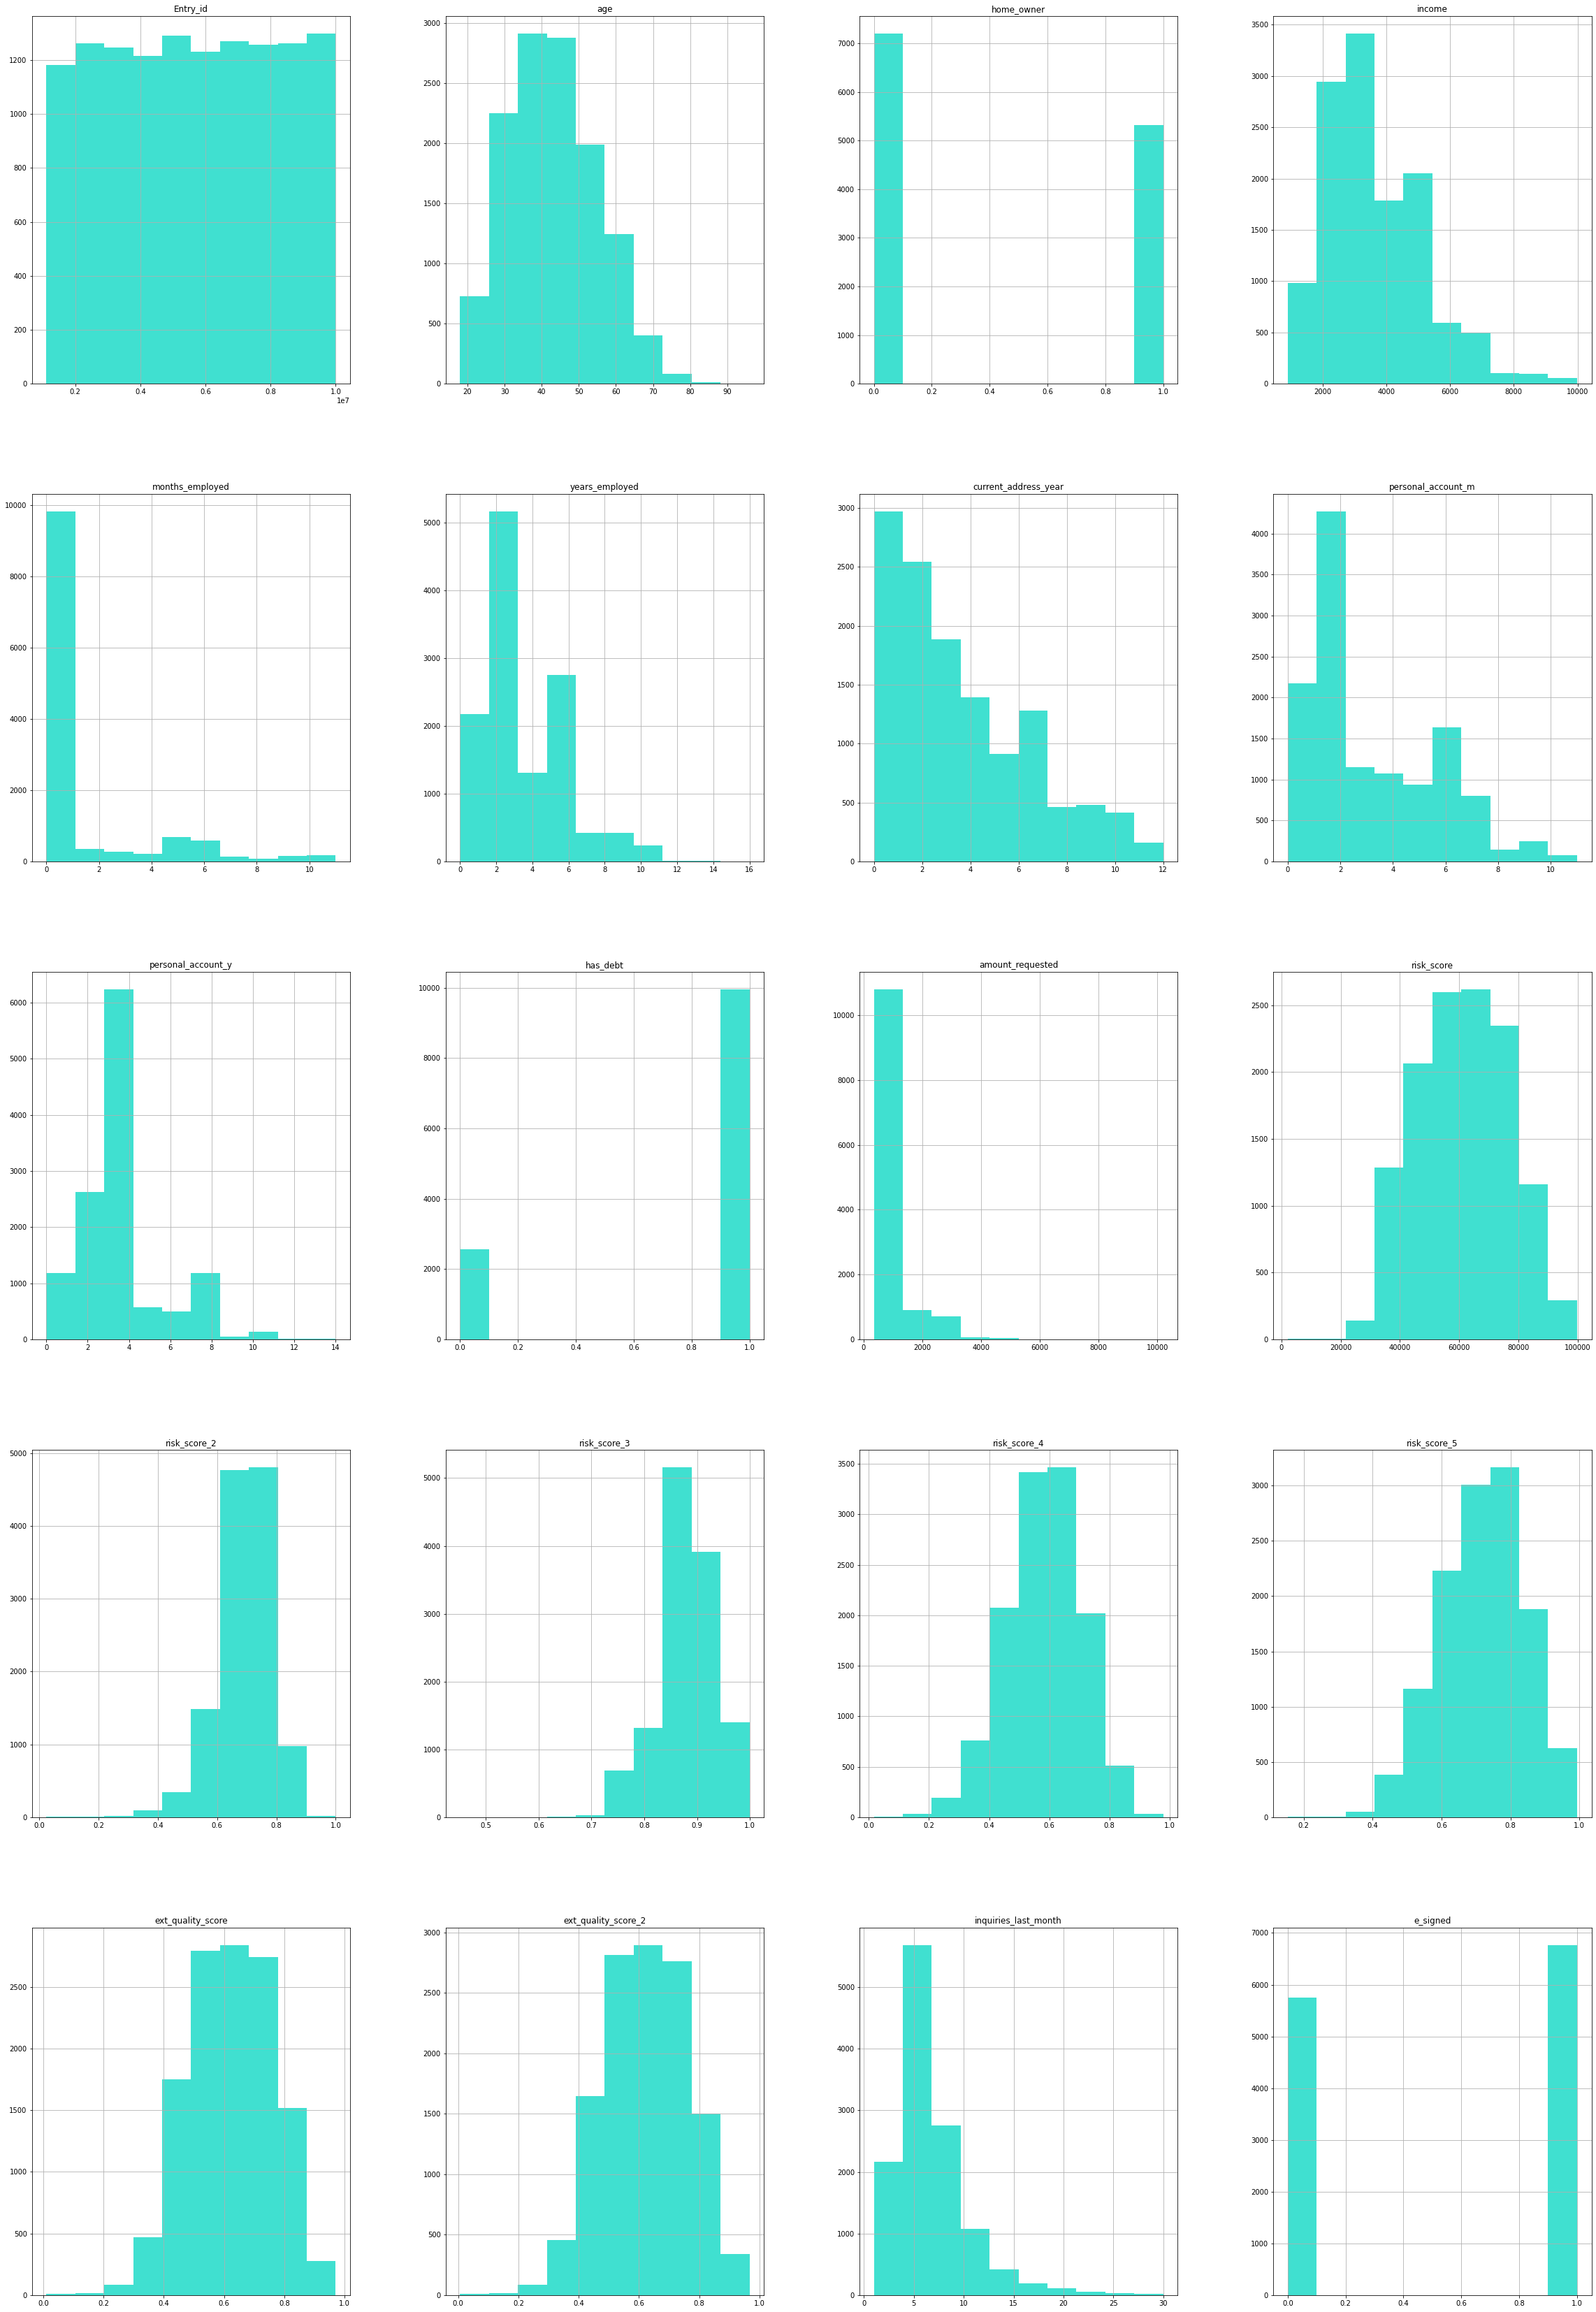

In [11]:
# to visualize the distribution of the data

train.hist(figsize = (40, 60), color = 'turquoise');

.

#### Percentage of clients that are e-signed 

This analysis is to investigate the percentage of the clients who got E_signed and not 

1    6766
0    5750
Name: e_signed, dtype: int64


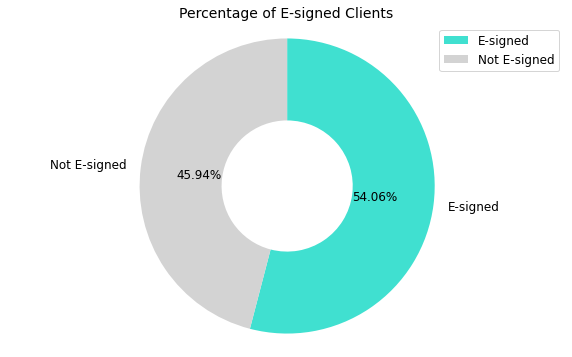

In [12]:
# to count the number of e-signed clients 
sorted_counts = train['e_signed'].value_counts()
print(sorted_counts)

# to represent it in a pie plot
plt.figure(figsize = (10,6))
labels = ['E-signed', 'Not E-signed']
plt.pie(sorted_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of E-signed Clients', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12)
plt.show();

> From this insight generated, it shows that more than 50% of the clients are E-signed 

#### Percentage of Clients that are E-signed and in debt

This Analysis was done to observe the percentage of clients that are E-signed and its relationship to their debt status 

1    9956
0    2560
Name: has_debt, dtype: int64


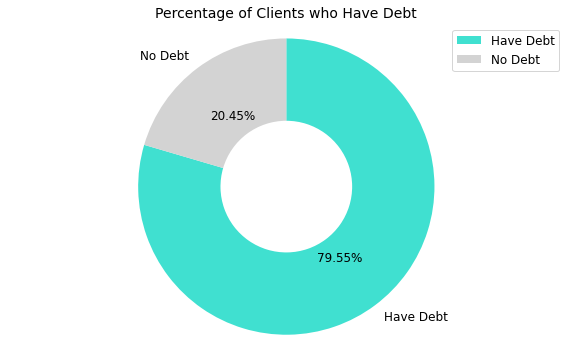

In [13]:
# first lets check the number of clients in debt
debt_counts = train['has_debt'].value_counts()
print(debt_counts)

# to represent it in a pie plot
plt.figure(figsize = (10,6))
labels = ['Have Debt', 'No Debt']
plt.pie(debt_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of Clients who Have Debt', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12)
plt.show();


1    5465
0    4491
Name: e_signed, dtype: int64
1    1301
0    1259
Name: e_signed, dtype: int64


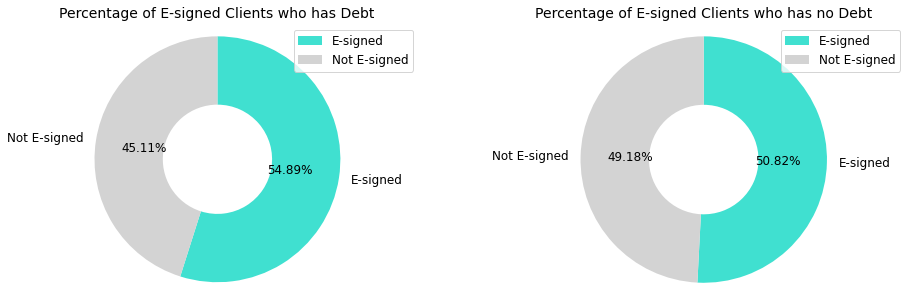

In [14]:
# to check have_debt along with e-signed to explore relationship
plt.figure(figsize = [16,5])

# left plot 
# this is for clients who have debt
plt.subplot(1,2,1)
debt = train[train['has_debt'] == 1]

# to count the number of e-signed clients
debt_esign_counts = debt['e_signed'].value_counts()
print(debt_esign_counts)

# to represent it in a pie plot
labels = ['E-signed', 'Not E-signed']
plt.pie(debt_esign_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of E-signed Clients who has Debt', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12)

# right plot
# this is for clients who do not have debt
plt.subplot(1,2,2)
not_debt = train[train['has_debt'] == 0]

# to count the number of e-signed clients
not_debt_esign_counts = not_debt['e_signed'].value_counts()
print(not_debt_esign_counts)

# to represent it in a pie plot
labels = ['E-signed', 'Not E-signed']
plt.pie(not_debt_esign_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of E-signed Clients who has no Debt', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12);

> - From the Analysis above, 79.55% (9,956) of the clients have debt while the remaining 20.45% (2,560) of the clients do not have debt.
>
> - Out of the 9,956 clients who have debt, 54.89% (5,465) of them are E-signed while the remaining 45.11% (4,491) of the clients are not E-signed. 
>
> - Out of the 2,560 clients who have no debt, 50.82% (1,301) of them are E-signed while the remaining 49.18% (1,259) of the clients are not E-signed. 

#### Percentage of Clients that are E-signed and house owners

This analysis aims to observe the percentage of clients that are house owners and observe the relationship with E-signed

0    7196
1    5320
Name: home_owner, dtype: int64


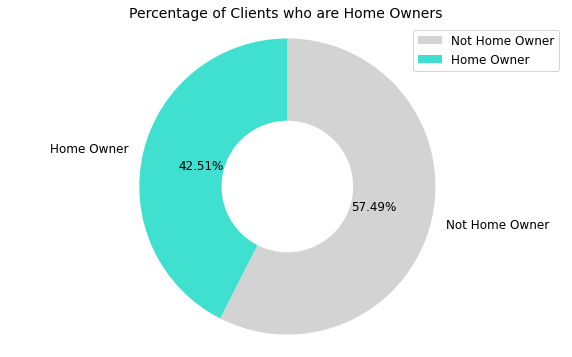

In [15]:
# first lets check the number of clients in debt
house_owner = train['home_owner'].value_counts()
print(house_owner)

# to represent it in a pie plot
plt.figure(figsize = (10,6))
labels = ['Not Home Owner', 'Home Owner']
plt.pie(house_owner, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['lightgray', 'turquoise'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of Clients who are Home Owners', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12)
plt.show();


1    2707
0    2613
Name: e_signed, dtype: int64
1    4059
0    3137
Name: e_signed, dtype: int64


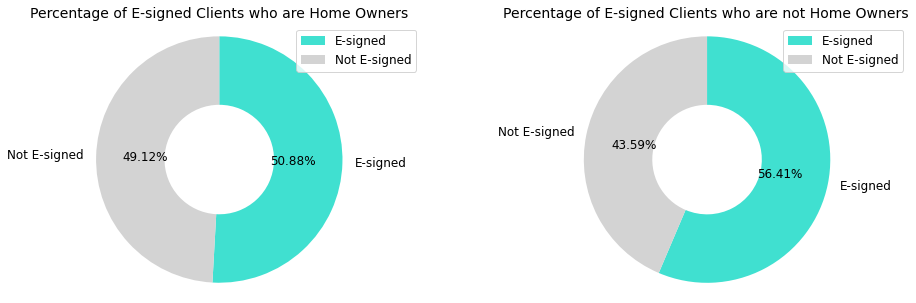

In [16]:
# to check House Owner along with e-signed to explore relationship
plt.figure(figsize = [16,5])

# left plot 
# this is for clients who have debt
plt.subplot(1,2,1)
home = train[train['home_owner'] == 1]

# to count the number of e-signed clients
home_esign_counts = home['e_signed'].value_counts()
print(home_esign_counts)

# to represent it in a pie plot
labels = ['E-signed', 'Not E-signed']
plt.pie(home_esign_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of E-signed Clients who are Home Owners', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12)

# right plot
# this is for clients who do not have debt
plt.subplot(1,2,2)
not_home = train[train['home_owner'] == 0]

# to count the number of e-signed clients
not_home_esign_counts = not_home['e_signed'].value_counts()
print(not_home_esign_counts)

# to represent it in a pie plot
labels = ['E-signed', 'Not E-signed']
plt.pie(not_home_esign_counts, labels = labels, radius = 1.8, autopct = '%0.2f%%', colors = ['turquoise', 'lightgray'],
        textprops = {'fontsize' : 12}, startangle= 90, counterclock= False, wedgeprops= {'width' : 1.0});
plt.axis('equal')
plt.title('Percentage of E-signed Clients who are not Home Owners', fontsize = 14 )
plt.legend(loc = 'upper right', fontsize = 12);

> - From the Analysis above, 42.51% (5,320) of the clients are Home Owners while the remaining 57.49% (7,196) of the clients are not Home Owners.
>
> - Out of the 5,320 clients who are Home Owners, 50.88% (2,707) of them are E-signed while the remaining 49.12% (2,613) of the clients are not E-signed. 
>
> - Out of the 7,196 clients who are not Home Owners, 56.41% (4,059) of them are E-signed while the remaining 43.59% (3,137) of the clients are not E-signed.

#### Age Distribution of the Clients with respect to E-signed

This analysis aims to observe the age distribution of the clients and its relationship to E-signed

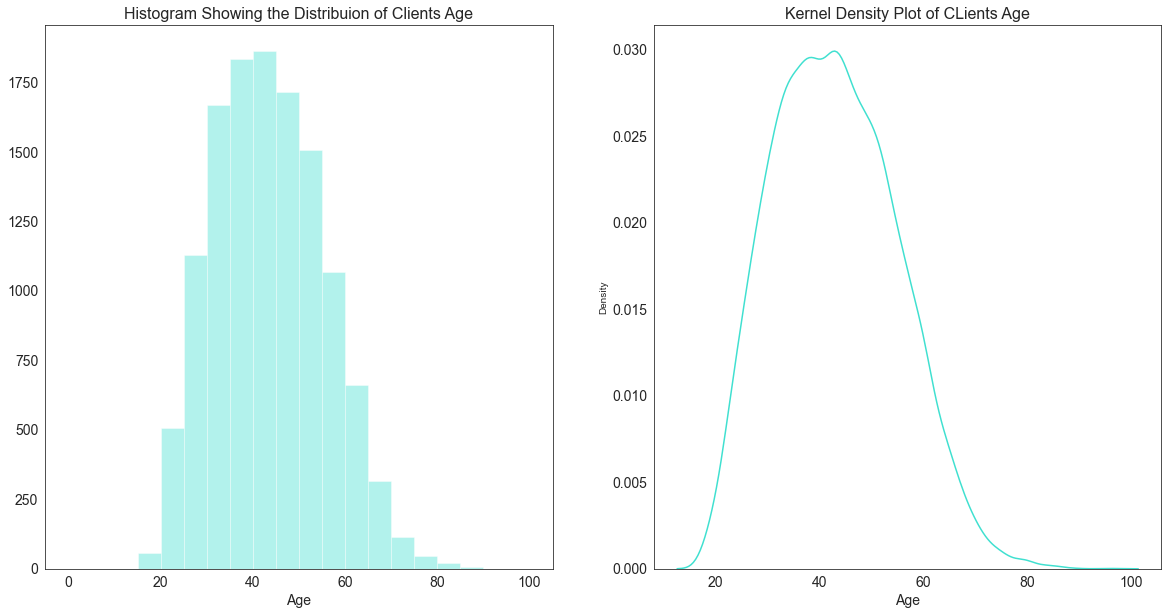

In [17]:
# first let us find the age distribution of the clients 
plt.figure(figsize= [20,10])
sns.set_style('white')

# left plot showing the histogram distribution of age
plt.subplot(1,2,1)
bins = np.arange(0, train['age'].max() + 5, 5)
sns.distplot(train['age'], kde = False, bins = bins, color= 'turquoise');
plt.title("Histogram Showing the Distribuion of Clients Age", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Age", fontsize = 14)

# right plot showing the kernel density plot of Client's Age
plt.subplot(1,2,2)
bins = np.arange(0, train['age'].max() + 5, 5)
sns.distplot(train['age'], hist = False, bins = bins, color= 'turquoise');
plt.title("Kernel Density Plot of CLients Age", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Age", fontsize = 14);

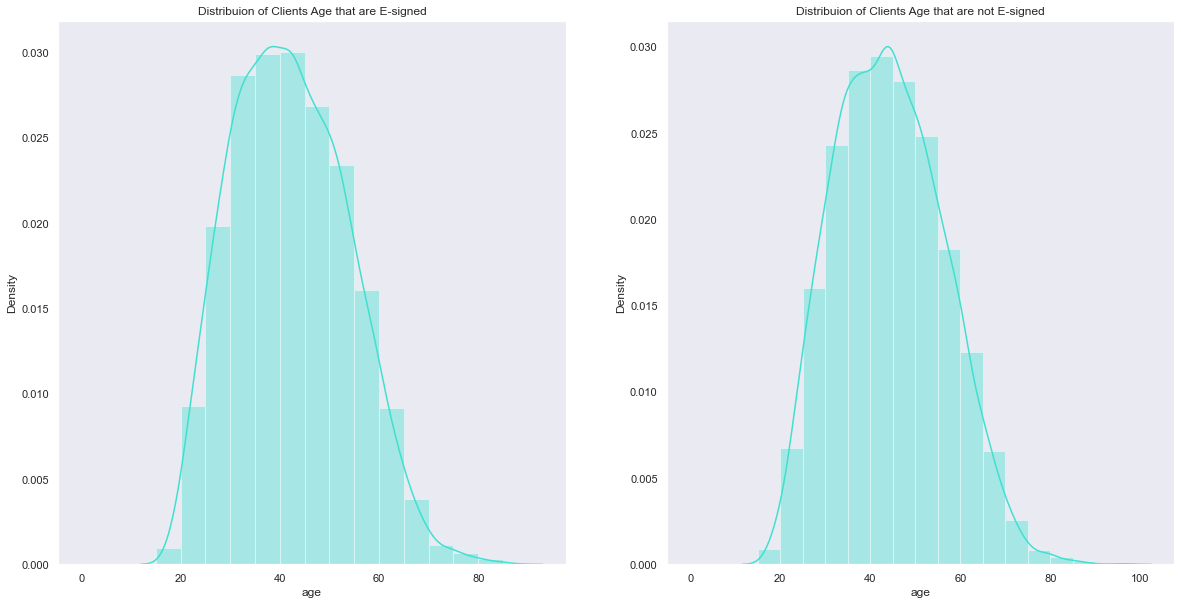

In [18]:
# let us observe the age distribution of the clients with respect to e-signed 
plt.figure(figsize= [20,10])
sns.set(style = 'dark')

# left plot showing the histogram distribution of age
plt.subplot(1,2,1)
esign = train[train['e_signed'] == 1]
bins = np.arange(0, esign['age'].max() + 5, 5)
sns.distplot(esign['age'], bins = bins, color= 'turquoise');
plt.title("Distribuion of Clients Age that are E-signed")

# right plot showing the kernel density plot of Client's Age
plt.subplot(1,2,2)
not_esign = train[train['e_signed'] == 0]
bins = np.arange(0, not_esign['age'].max() + 5, 5)
sns.distplot(not_esign['age'], bins = bins, color= 'turquoise');
plt.title("Distribuion of Clients Age that are not E-signed");


> From the Analysis above, ages 40-45 appears to be the most age gaps among the clients. This distribution does not change when observed alongside the e-signed column. The age distribution does not have an relationship with the E-signed process 

#### Examining the Number of clients and their pay schedule

This analysis aims to observe the pay schedule of the clients then look for its relationship with e-signed

In [19]:
# observing the overview of the table
train.head()

Entry_id  age  pay_schedule  home_owner  income  months_employed  \
0   7629673   40     bi-weekly           1    3135                0   
1   5335819   33  semi-monthly           0    3590                0   
2   8492423   21        weekly           0    2303                0   
3   7948313   26     bi-weekly           0    2795                0   
4   4297036   43     bi-weekly           0    5000                0   

   years_employed  current_address_year  personal_account_m  \
0               3                     3                   6   
1               5                     2                   2   
2               5                     8                   2   
3               4                     4                   1   
4               2                     1                   1   

   personal_account_y  has_debt  amount_requested  risk_score  risk_score_2  \
0                   2         1               550       36200      0.737398   
1                   8         1              1100       53850      0.617361   
2                   7         1               600       74850      0.677109   
3                   6         1               800       50800      0.738055   
4                   2         1              1100       69100      0.798303   

   risk_score_3  risk_score_4  risk_score_5  ext_quality_score  \
0      0.903517      0.487712      0.515977           0.580918   
1      0.857560      0.613487      0.665523           0.744634   
2      0.758765      0.495609      0.664762           0.592556   
3      0.873204      0.666437      0.700392           0.584130   
4      0.841747      0.401971      0.568787           0.525905   

   ext_quality_score_2  inquiries_last_month  e_signed  
0             0.380918                    10         1  
1             0.744634                    12         0  
2             0.492556                     6         1  
3             0.684130                    14         1  
4             0.725905                     5         1

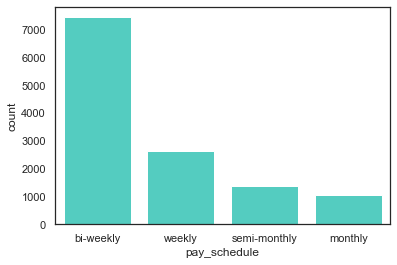

In [20]:
# to plot a countplot 
sns.set_style('white')
counts = train['pay_schedule'].value_counts()
counts_order = counts.index
sns.countplot(data = train, x = 'pay_schedule', color= 'turquoise', order= counts_order);

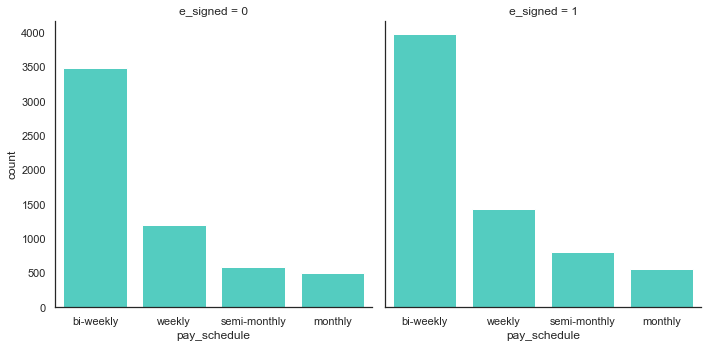

In [21]:
# to examine the countplot based on E-signed 
counts = train['pay_schedule'].value_counts()
counts_order = counts.index
sns.catplot(data = train, x = 'pay_schedule', kind = 'count', color= 'turquoise', order= counts_order, col = 'e_signed');
plt.show();

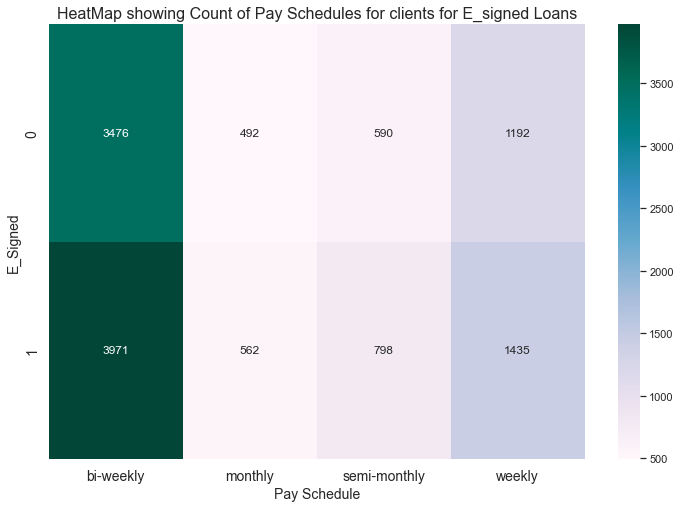

In [22]:
# for clarity purpose, a heatmap is plotted to show the counts 
plt.figure(figsize= (12,8))
pay_counts = train.groupby(['pay_schedule','e_signed']).size()
pay_counts = pay_counts.reset_index(name= 'count')
pay_counts = pay_counts.pivot(columns = 'pay_schedule', index = 'e_signed', values= 'count')
sns.heatmap(pay_counts, annot= True, fmt= 'd', cmap= 'PuBuGn')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('E_Signed', fontsize = 14)
plt.xlabel('Pay Schedule', fontsize = 14)
plt.title("HeatMap showing Count of Pay Schedules for clients for E_signed Loans", fontsize= 16);

> From the analysis above, Mosgt of our clients earn biweekly followed by Monthly and weekly being the least. 
>
> After observing the pay schedule with e-signed column, a relationship was not spotted.

#### Examining the distribution of amount requested

In [23]:
train['amount_requested'].describe()

count    12516.000000
mean       950.251518
std        706.915146
min        350.000000
25%        600.000000
50%        700.000000
75%       1100.000000
max      10200.000000
Name: amount_requested, dtype: float64

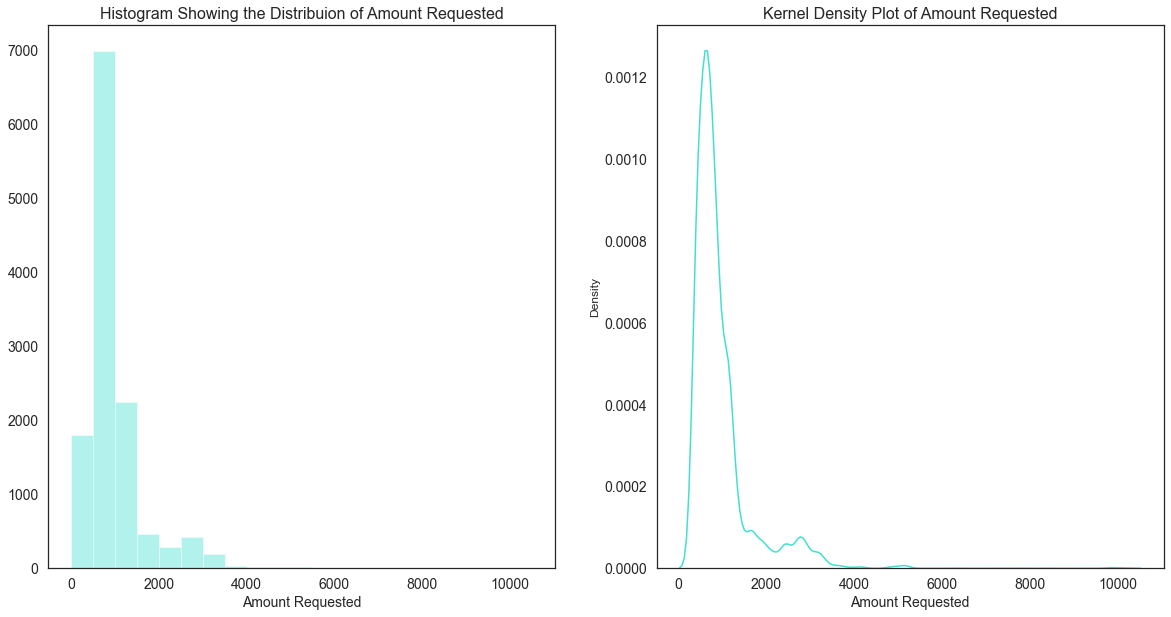

In [24]:
# first let us find the distribution of the amount requested by clients 
plt.figure(figsize= [20,10])

# left plot showing the histogram distribution of amount requested by clients
plt.subplot(1,2,1)
bins = np.arange(0, train['amount_requested'].max() + 500, 500)
sns.distplot(train['amount_requested'], kde = False, bins = bins, color= 'turquoise');
plt.title("Histogram Showing the Distribuion of Amount Requested", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Amount Requested", fontsize = 14)

# right plot showing the kernel density plot of amount requested by clients
plt.subplot(1,2,2)
bins = np.arange(0, train['amount_requested'].max() + 500, 500)
sns.distplot(train['amount_requested'], hist = False, bins = bins, color= 'turquoise');
plt.title("Kernel Density Plot of Amount Requested", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Amount Requested", fontsize = 14);

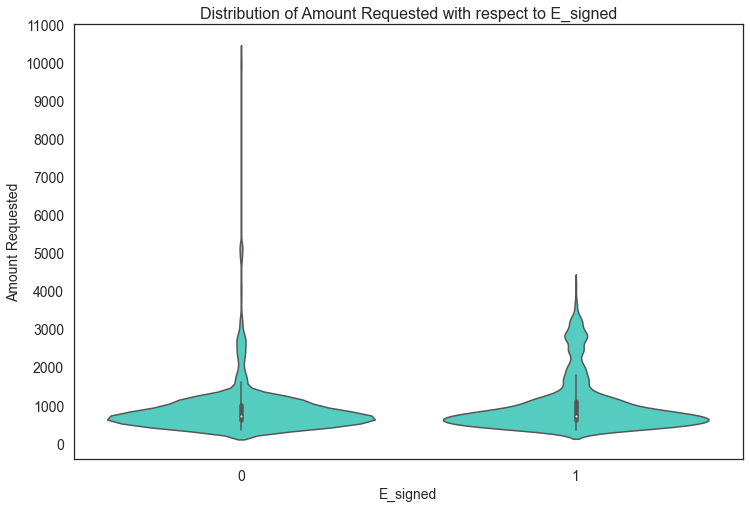

In [25]:
# to examine the relationship between Amount requested and e-signed
plt.figure(figsize= (12,8))
sns.violinplot(data= train, x = 'e_signed', y= 'amount_requested', color= 'turquoise')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000], fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Amount Requested', fontsize = 14)
plt.xlabel('E_signed', fontsize = 14)
plt.title("Distribution of Amount Requested with respect to E_signed", fontsize= 16);

After observing the distribution of the amount requested, we figured out that majority of the amount requested fell within 500 - 1500. The distribution was also observed with respect to the E_signed status and we observed that, clients who are E-signed did not request for amounts greater than 4500 while clients who are not E_signed have requested for loan amount up to 10000

#### To Examine the relationship between income and amount requested

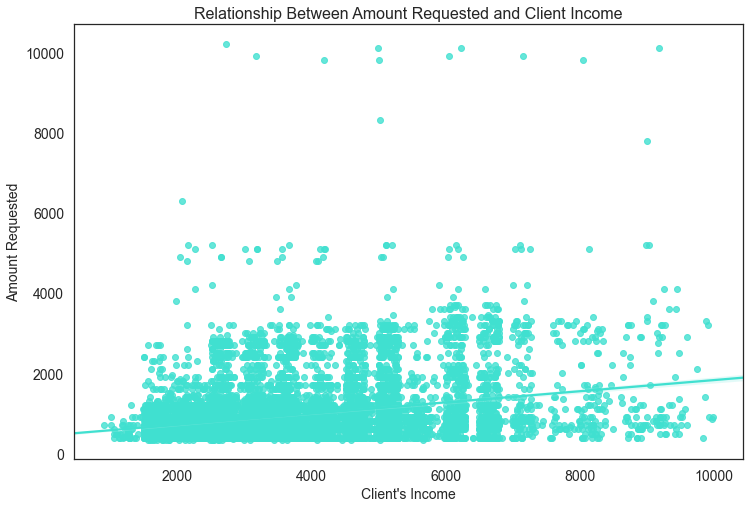

In [26]:
# to plot a scatter plot income and amount requested
plt.figure(figsize= (12,8))
sns.regplot(x = 'income', y = 'amount_requested', data = train, color = 'turquoise', truncate= False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Amount Requested', fontsize = 14)
plt.xlabel("Client's Income", fontsize = 14)
plt.title("Relationship Between Amount Requested and Client Income", fontsize= 16)
plt.show();

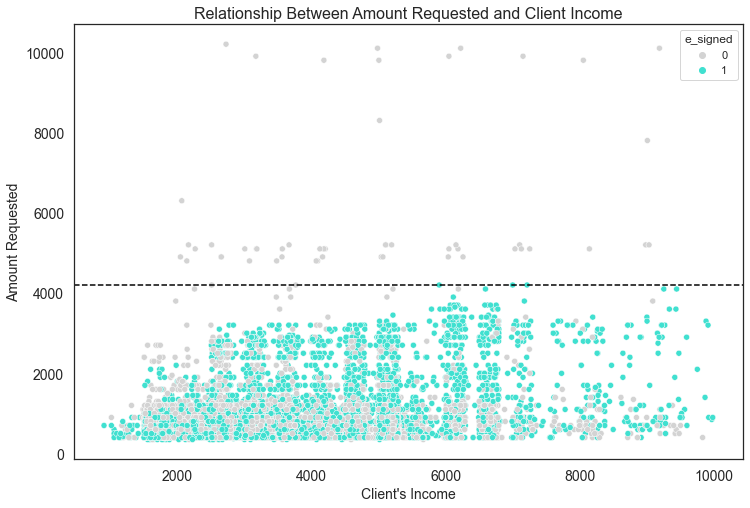

In [27]:
plt.figure(figsize= (12,8))
hue_colors = {0: 'lightgray', 1: 'turquoise'}
sns.scatterplot(x = 'income', y = 'amount_requested', hue= 'e_signed', data = train, palette= hue_colors)

# setting an amount requested mark at 4200
plt.axhline(4200, ls= '--', color= 'black')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Amount Requested', fontsize = 14)
plt.xlabel("Client's Income", fontsize = 14)
plt.title("Relationship Between Amount Requested and Client Income", fontsize= 16)
plt.show();

<Figure size 1440x864 with 0 Axes>

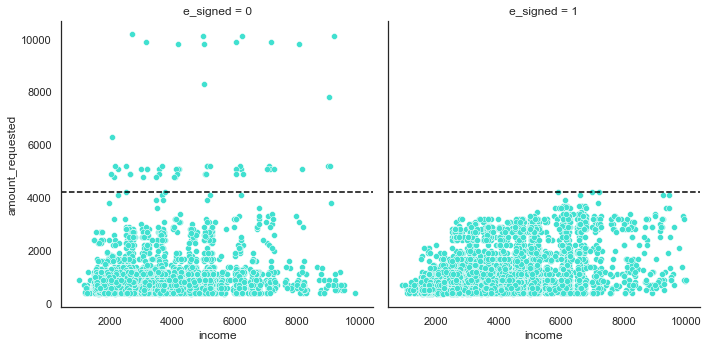

In [28]:
# to seperate the scatterplot based on e-signed
plt.figure(figsize=[20, 12])
g = sns.relplot(x = 'income', y = 'amount_requested', data = train, kind = 'scatter', col = 'e_signed', color = 'turquoise')
axes = g.axes.flatten()

for i, ax in enumerate(axes):
    ax.axhline(4200, ls = '--', c = 'black')
plt.show();

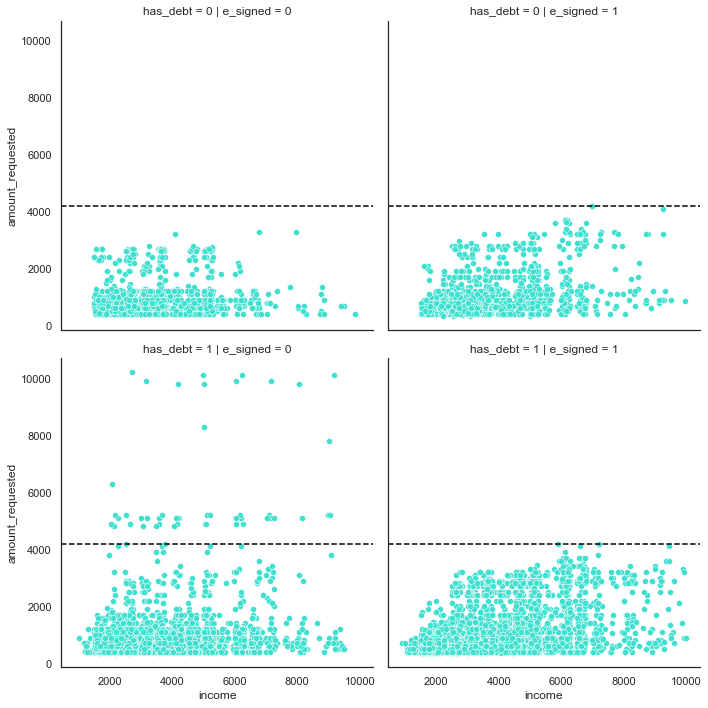

In [29]:
# to seperate the scatterplot based on e-signed and has debt

g = sns.relplot(x = 'income', y = 'amount_requested', data = train, kind = 'scatter', col = 'e_signed', row = 'has_debt',
            color = 'turquoise')
axes = g.axes.flatten()

for i, ax in enumerate(axes):
    ax.axhline(4200, ls = '--', c = 'black')

plt.show();

> From the analysis above, we deduced that clients who requested for amounts greater than 4200 got rejected for their loan approval (E-signed) irrespective of the clients income.

> On further investigation, we figured out the clients who requested above the certain benchmark of 4200 are clients who are not E_signed and who are in debt. 

### Examining the relationship between risk score and external quality score and Income

THis analysis aims to observe the relationship between risk score, external quality score and income

In [30]:
# to calculate the mean external quality score
train['mean_quality'] = train[['ext_quality_score', 'ext_quality_score_2']].mean(axis = 1)

# to calculate the mean risk score using risk score 2, 3, 4 & 5
col = train.loc[:, "risk_score_2":"risk_score_5"]
train['mean_risk_score'] = col.mean(axis= 1)

# to check if the columns have been added
train.head();

   mean_risk_score  mean_quality  income
0         0.661151      0.480918    3135
1         0.688483      0.744634    3590
2         0.649061      0.542556    2303
3         0.744522      0.634130    2795
4         0.652702      0.625905    5000


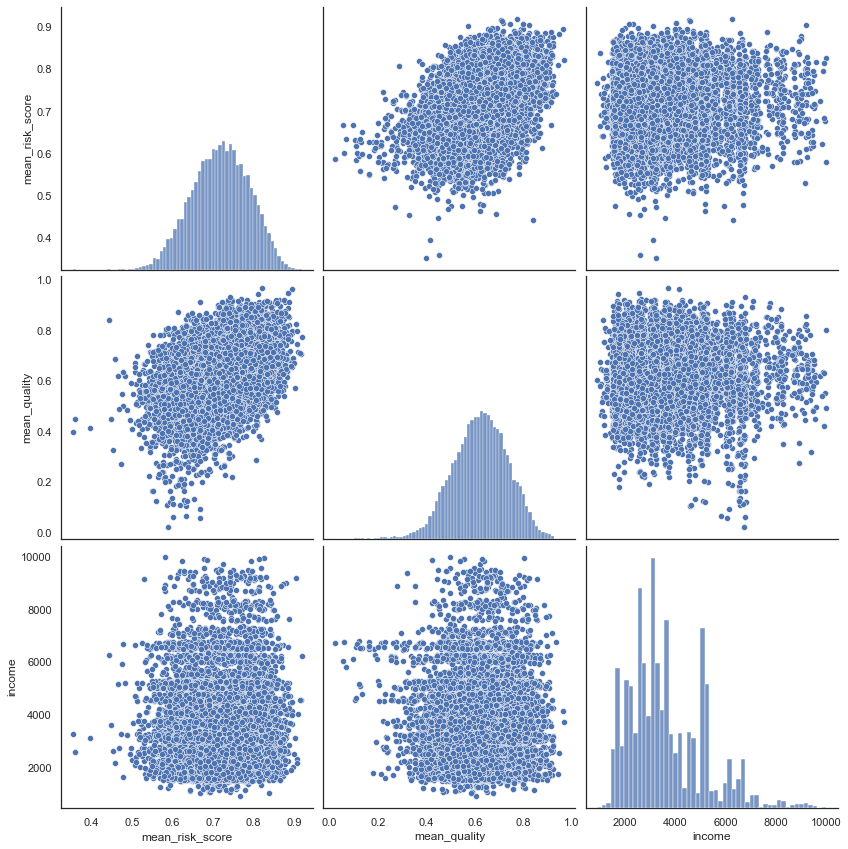

In [31]:
# to check the relationship between mean_risk_score, ext_quality_score and income
column = train[['mean_risk_score', 'mean_quality', 'income']]
print(column.head())

# using pairplot to observe relationships
sns.pairplot(column, height= 4);

In [32]:
# to check the correlation between mean quality score and mean risk score
train['mean_risk_score'].corr(train['mean_quality'])

0.4190188215401355

> A positive correlation of 0.42 was observed between the mean quality score and the mean risk score

To observe the relationship with respect to E-signed

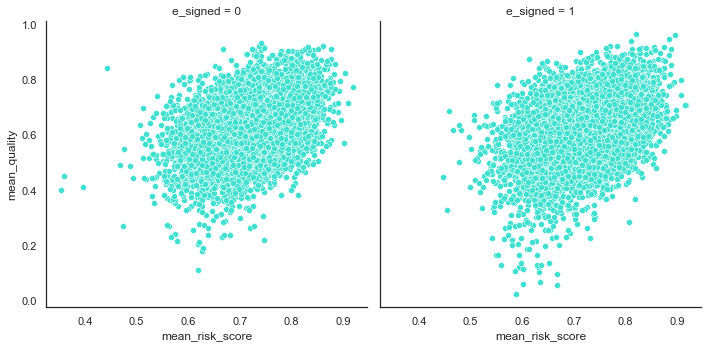

In [33]:
sns.relplot(data= train, x = 'mean_risk_score', y = 'mean_quality', col= 'e_signed', kind= 'scatter', color = 'turquoise')
plt.show();

In [34]:
# to check the correlation
esign = train[train['e_signed'] == 1]
not_esign = train[train['e_signed'] == 0]

esign_cor = esign['mean_risk_score'].corr(esign['mean_quality'])
not_esign_cor = not_esign['mean_risk_score'].corr(not_esign['mean_quality'])

print(esign_cor)
print(not_esign_cor)

0.4270416332733701
0.40958524675311725


> From this analysis, there is a stronger correlation between mean quality and mean risk score for e_signed clients compared to clients who are not e_signed

#### To Examine the relationship between number of enquiries last month and E-signed

THis analysis aims to study the relationship between the number of enquiries last month and the E_signed status

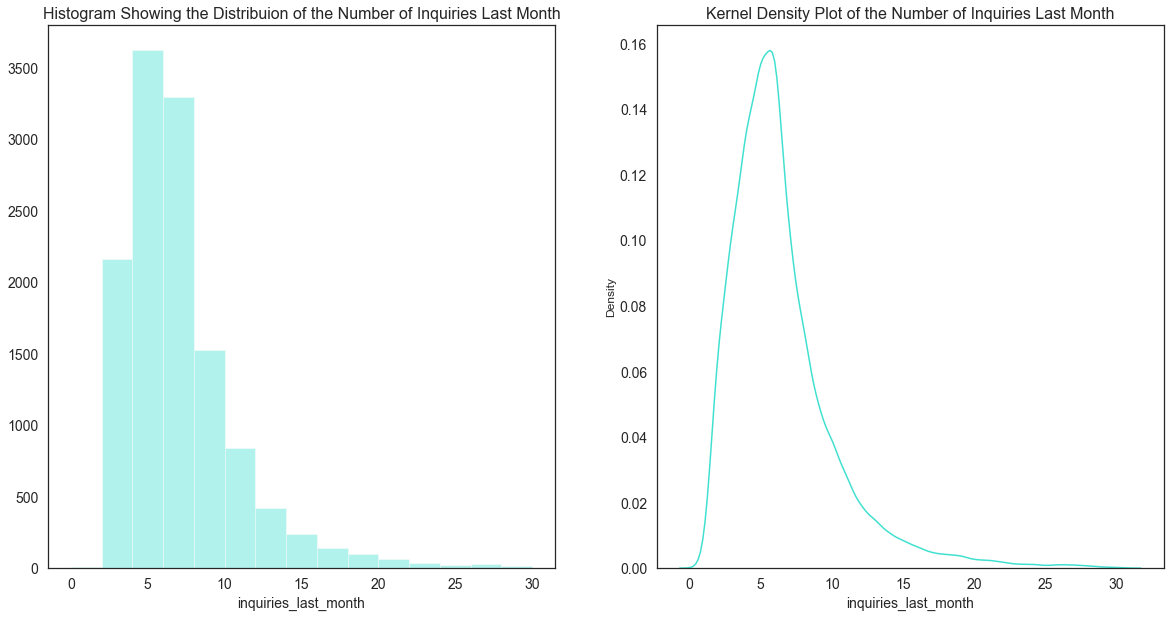

In [35]:
# first let us find the distribution of the Number of Inquiries Last Month
plt.figure(figsize= [20,10])

# left plot showing the histogram distribution of Number of Inquiries Last Month
plt.subplot(1,2,1)
bins = np.arange(0, train['inquiries_last_month'].max() + 2, 2)
sns.distplot(train['inquiries_last_month'], kde = False, bins = bins, color= 'turquoise');
plt.title("Histogram Showing the Distribuion of the Number of Inquiries Last Month", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("inquiries_last_month", fontsize = 14)

# right plot showing the kernel density plot of Number of Inquiries Last Month
plt.subplot(1,2,2)
bins = np.arange(0, train['inquiries_last_month'].max() + 4, 4)
sns.distplot(train['inquiries_last_month'], hist = False, bins = bins, color= 'turquoise');
plt.title("Kernel Density Plot of the Number of Inquiries Last Month", fontsize= 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("inquiries_last_month", fontsize = 14);

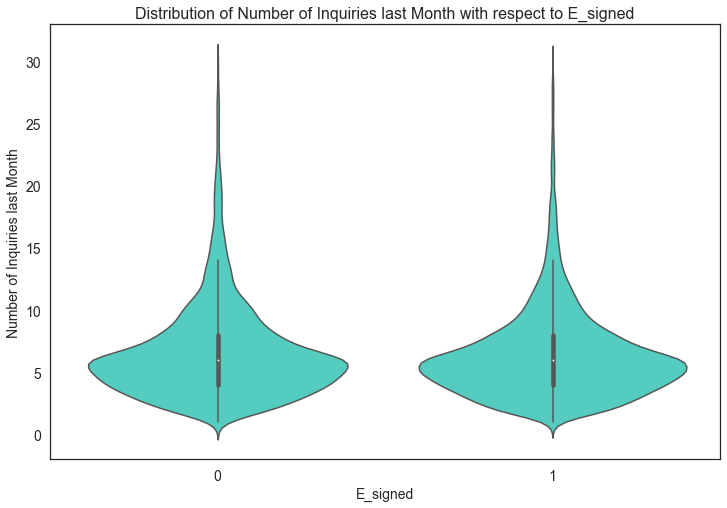

In [36]:
# to examine the relationship between Amount requested and e-signed
plt.figure(figsize= (12,8))
sns.violinplot(data= train, x = 'e_signed', y= 'inquiries_last_month', color= 'turquoise')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Number of Inquiries last Month', fontsize = 14)
plt.xlabel('E_signed', fontsize = 14)
plt.title("Distribution of Number of Inquiries last Month with respect to E_signed", fontsize= 16);

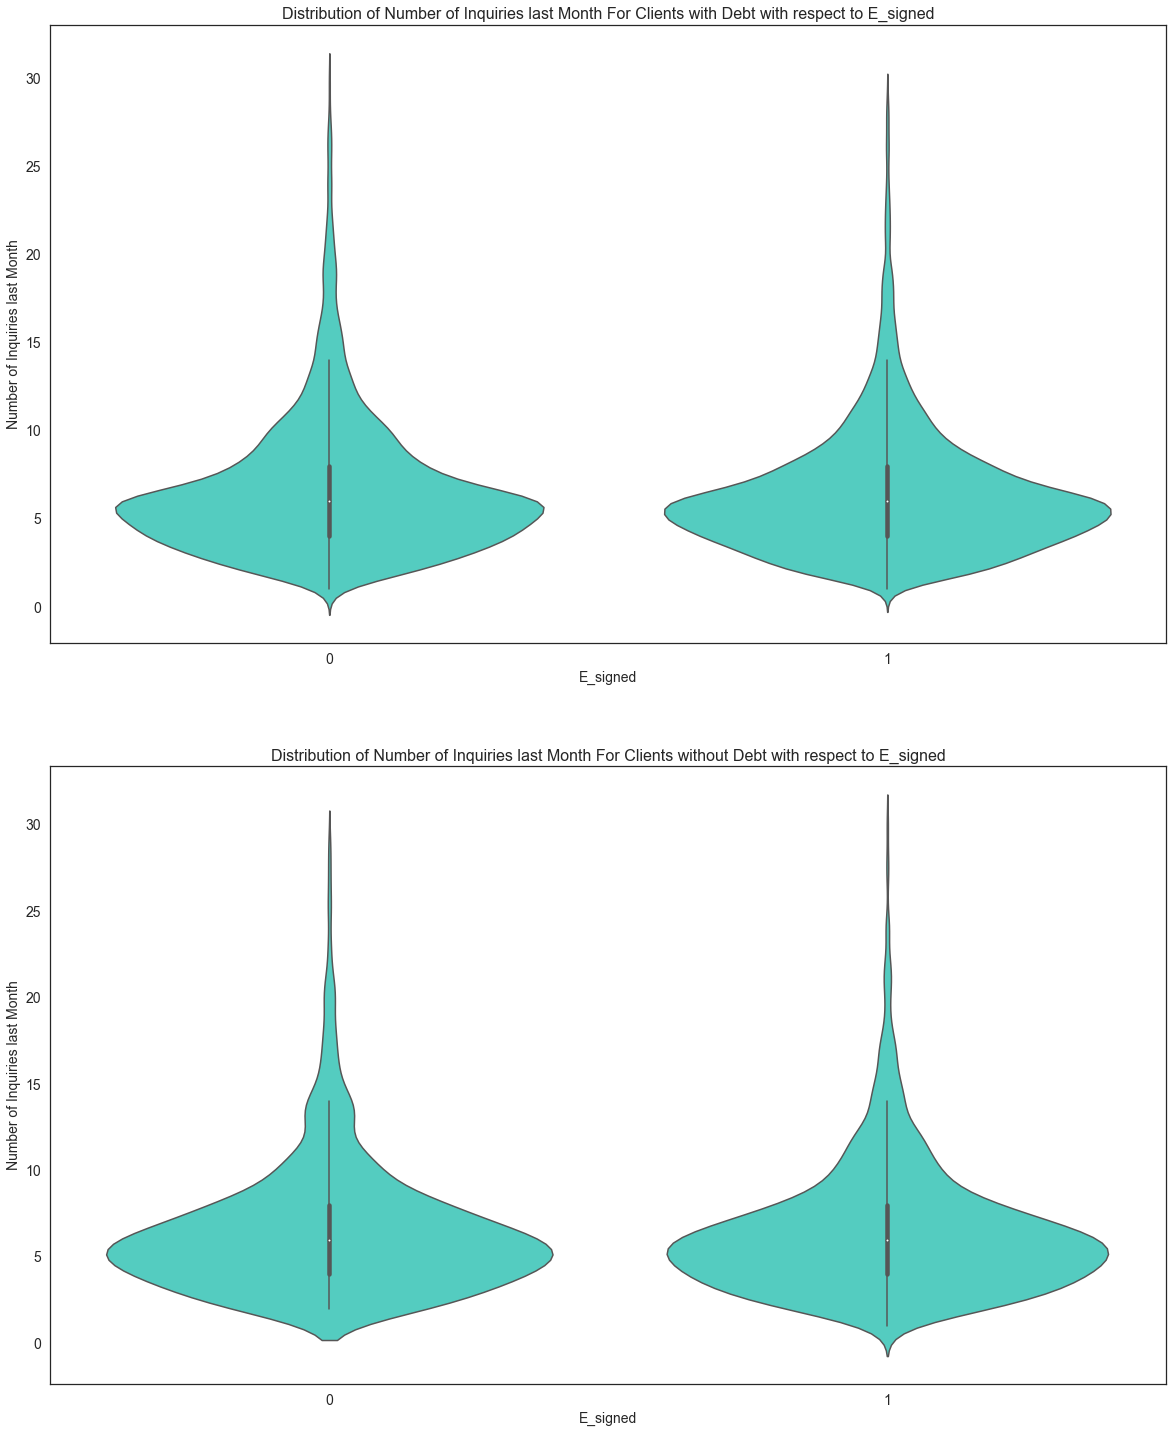

In [37]:
# to examine the relationship further using has_debt variable
plt.figure(figsize= [20,25])

debts = train[train['has_debt'] == 1]
nodebts = train[train['has_debt'] == 0]

# left plot is for clients who have debt
plt.subplot(2,1,1)
sns.violinplot(data= debts, x = 'e_signed', y= 'inquiries_last_month', color= 'turquoise')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Number of Inquiries last Month', fontsize = 14)
plt.xlabel('E_signed', fontsize = 14)
plt.title("Distribution of Number of Inquiries last Month For Clients with Debt with respect to E_signed", fontsize= 16);

# right plot is for clients who do not have debt
plt.subplot(2,1,2)
sns.violinplot(data= nodebts, x = 'e_signed', y= 'inquiries_last_month', color= 'turquoise')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Number of Inquiries last Month', fontsize = 14)
plt.xlabel('E_signed', fontsize = 14)
plt.title("Distribution of Number of Inquiries last Month For Clients without Debt with respect to E_signed", fontsize= 16);

> From the Analysis above, The distribution of the number of enquiries per month had its peak around 4-8 inquiries. 

> On observing the relationship between the distribution and the E_signed column, there was no observed relationship between the two variables.

### Conclusion:

The features included in the dataset holds relationships that can be inferred to the target variable, hence they'd be preprocessed and sequentially used to develop a model for an optimal solution

_______________________________________________

## Model Development:

In [38]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [39]:
# computing 'class_weight'
from sklearn.utils import class_weight
class_weight = dict(zip(np.unique(train['e_signed']), class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train['e_signed']),
                                                                                        y = train['e_signed']))) 
class_weight

{0: 1.0883478260869566, 1: 0.9249187112030742}

In [40]:
#stratified kfold validation scheme:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 752)

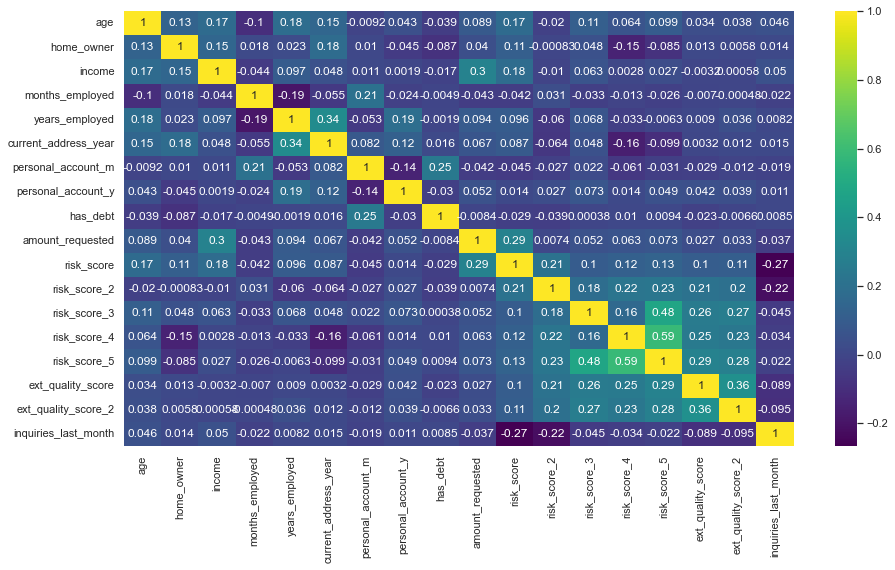

In [41]:
# checking for correlations that can be explored for feature engineering;
plt.figure(figsize=(15,8))
sns.heatmap(train.iloc[:,1:train.shape[1]-1].corr(),annot=True, cmap='viridis');

##### Feature Engineering;

In [42]:
X = train.drop(['Entry_id','e_signed'], axis=1)
y = train.e_signed
# -----------------------------------------------------------------
X_pay_schedule = pd.get_dummies(X['pay_schedule']) #dummy variables;
X_copy = pd.concat((X,X_pay_schedule), axis=1)
X_copy.drop('pay_schedule',axis=1,inplace=True)
X = X_copy.copy()

# on test_dataset:
test_entry_Id = test['Entry_id']
test_pay_schedule = pd.get_dummies(test['pay_schedule'])
test_copy = pd.concat((test,test_pay_schedule), axis=1)
test_copy.drop('pay_schedule',axis=1,inplace=True)
test_copy.drop('Entry_id',axis=1,inplace=True)

In [43]:
'''discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

X['income_bins'] = discretizer.fit_transform(X['income'].values.reshape(-1,1).astype('float'))

X['amount_requested_bin'] = discretizer.fit_transform(X['amount_requested'].values.reshape(-1,1).astype('float'))

X['mean_risk_score'] = X[['risk_score_2','risk_score_3','risk_score_4',	'risk_score_5']].mean(axis=1)

X['mean_ext_quality'] = X[['ext_quality_score','ext_quality_score_2']].mean(axis=1)'''

"discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')\n\nX['income_bins'] = discretizer.fit_transform(X['income'].values.reshape(-1,1).astype('float'))\n\nX['amount_requested_bin'] = discretizer.fit_transform(X['amount_requested'].values.reshape(-1,1).astype('float'))\n\nX['mean_risk_score'] = X[['risk_score_2','risk_score_3','risk_score_4',\t'risk_score_5']].mean(axis=1)\n\nX['mean_ext_quality'] = X[['ext_quality_score','ext_quality_score_2']].mean(axis=1)"

In [44]:
X.head()

age  home_owner  income  months_employed  years_employed  \
0   40           1    3135                0               3   
1   33           0    3590                0               5   
2   21           0    2303                0               5   
3   26           0    2795                0               4   
4   43           0    5000                0               2   

   current_address_year  personal_account_m  personal_account_y  has_debt  \
0                     3                   6                   2         1   
1                     2                   2                   8         1   
2                     8                   2                   7         1   
3                     4                   1                   6         1   
4                     1                   1                   2         1   

   amount_requested  risk_score  risk_score_2  risk_score_3  risk_score_4  \
0               550       36200      0.737398      0.903517      0.487712   
1              1100       53850      0.617361      0.857560      0.613487   
2               600       74850      0.677109      0.758765      0.495609   
3               800       50800      0.738055      0.873204      0.666437   
4              1100       69100      0.798303      0.841747      0.401971   

   risk_score_5  ext_quality_score  ext_quality_score_2  inquiries_last_month  \
0      0.515977           0.580918             0.380918                    10   
1      0.665523           0.744634             0.744634                    12   
2      0.664762           0.592556             0.492556                     6   
3      0.700392           0.584130             0.684130                    14   
4      0.568787           0.525905             0.725905                     5   

   bi-weekly  monthly  semi-monthly  weekly  
0          1        0             0       0  
1          0        0             1       0  
2          0        0             0       1  
3          1        0             0       0  
4          1        0             0       0

In [45]:
# in other to capture non-linear relationships, we compute the mutual_information_score of the features;
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


# to plot the score of Mutual Information 
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

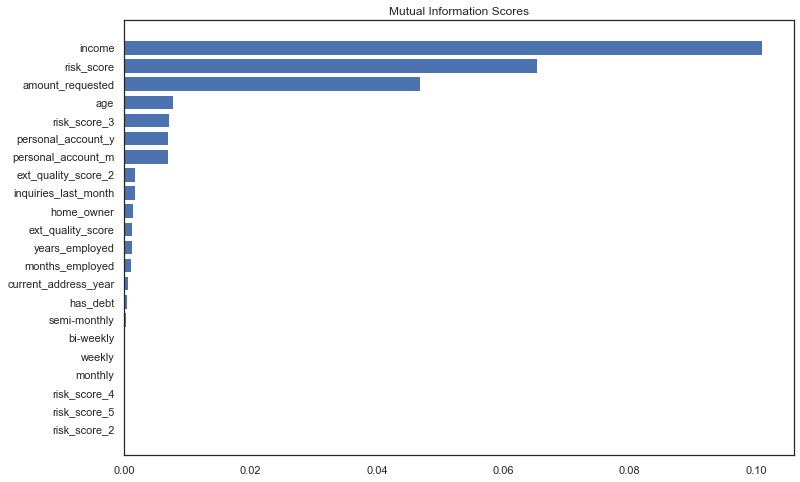

In [46]:
mi_scores = make_mi_scores(X,y)

plt.figure(figsize=(12,8))
plot_mi_scores(mi_scores)

from the plot above and the correlation as well as the EDA carried earlier, the features shows to hold information that can be exploited to make a robust model:

### Model Building:

*Training a **LightGBM** classifier:*

In [47]:
lgb_clf = LGBMClassifier(random_state=752, class_weight=class_weight)

In [48]:
# Carrying Hyper Parameter Optuna Optimization using a Bayesian Optimizer;
def objective(trial):
    params ={
    'max_bin': trial.suggest_int('max_bin', 30, 150),
    'max_depth': trial.suggest_int('max_depth', 4, 15),
    'subsample': trial.suggest_uniform('subsample', 0.6,  1.0),
    'min_child_samples': trial.suggest_int('min_child_samples', 30, 100),
    'num_leaves': trial.suggest_int('num_leaves', 30, 100),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 0.9),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.1,  0.4),
    'bagging_freq': trial.suggest_int('bagging_freq', 6, 10),
    'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 10.0),
    'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 10.0),
    }
    lgb_clf.set_params(**params)

    
    
    return np.mean(cross_val_score(lgb_clf, X, y, cv=skf, scoring='roc_auc'))

In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2022-10-06 03:57:59,083] A new study created in memory with name: no-name-fa6ce0eb-ee78-4a14-bf6b-7cb52403ebf3


[LightGBM] [Warning] lambda_l1 is set=0.3509734380226248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3509734380226248
[LightGBM] [Warning] lambda_l2 is set=6.420478581924752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.420478581924752
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=0.3509734380226248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3509734380226248
[LightGBM] [Warning] lambda_l2 is set=6.420478581924752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.420478581924752
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=0.3509734380226248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3509734380226248
[LightGBM] [Warning] lambda_l2 is set=6.420478581924752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.42047

[I 2022-10-06 03:58:03,734] Trial 0 finished with value: 0.6873196311303937 and parameters: {'max_bin': 32, 'max_depth': 6, 'subsample': 0.6703472507837862, 'min_child_samples': 54, 'num_leaves': 54, 'colsample_bytree': 0.6891330163168716, 'learning_rate': 0.11548584029885742, 'bagging_freq': 8, 'lambda_l1': 0.3509734380226248, 'lambda_l2': 6.420478581924752}. Best is trial 0 with value: 0.6873196311303937.


[LightGBM] [Warning] lambda_l1 is set=2.2958968147271808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2958968147271808
[LightGBM] [Warning] lambda_l2 is set=6.092403302724836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.092403302724836
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.2958968147271808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2958968147271808
[LightGBM] [Warning] lambda_l2 is set=6.092403302724836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.092403302724836
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.2958968147271808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2958968147271808
[LightGBM] [Warning] lambda_l2 is set=6.092403302724836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.09240

[I 2022-10-06 03:58:10,256] Trial 1 finished with value: 0.6618651392229296 and parameters: {'max_bin': 67, 'max_depth': 9, 'subsample': 0.7116554814049829, 'min_child_samples': 82, 'num_leaves': 70, 'colsample_bytree': 0.7966839046266596, 'learning_rate': 0.35150895992635023, 'bagging_freq': 9, 'lambda_l1': 2.2958968147271808, 'lambda_l2': 6.092403302724836}. Best is trial 0 with value: 0.6873196311303937.


[LightGBM] [Warning] lambda_l1 is set=2.327719190438078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327719190438078
[LightGBM] [Warning] lambda_l2 is set=8.482242201396767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.482242201396767
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=2.327719190438078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327719190438078
[LightGBM] [Warning] lambda_l2 is set=8.482242201396767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.482242201396767
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=2.327719190438078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327719190438078
[LightGBM] [Warning] lambda_l2 is set=8.482242201396767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.48224220139

[I 2022-10-06 03:58:24,142] Trial 2 finished with value: 0.6883476505216228 and parameters: {'max_bin': 65, 'max_depth': 15, 'subsample': 0.959458993960455, 'min_child_samples': 41, 'num_leaves': 76, 'colsample_bytree': 0.8874810775046236, 'learning_rate': 0.20060419894750448, 'bagging_freq': 8, 'lambda_l1': 2.327719190438078, 'lambda_l2': 8.482242201396767}. Best is trial 2 with value: 0.6883476505216228.


[LightGBM] [Warning] lambda_l1 is set=6.9802869075781455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9802869075781455
[LightGBM] [Warning] lambda_l2 is set=4.470621975782636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.470621975782636
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=6.9802869075781455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9802869075781455
[LightGBM] [Warning] lambda_l2 is set=4.470621975782636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.470621975782636
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=6.9802869075781455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9802869075781455
[LightGBM] [Warning] lambda_l2 is set=4.470621975782636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.47062

[I 2022-10-06 03:58:30,551] Trial 3 finished with value: 0.6699661272909472 and parameters: {'max_bin': 50, 'max_depth': 11, 'subsample': 0.687695151548648, 'min_child_samples': 69, 'num_leaves': 31, 'colsample_bytree': 0.8868032598544134, 'learning_rate': 0.34467594552528263, 'bagging_freq': 9, 'lambda_l1': 6.9802869075781455, 'lambda_l2': 4.470621975782636}. Best is trial 2 with value: 0.6883476505216228.


[LightGBM] [Warning] lambda_l1 is set=1.741423603233364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.741423603233364
[LightGBM] [Warning] lambda_l2 is set=2.159165234346064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.159165234346064
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.741423603233364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.741423603233364
[LightGBM] [Warning] lambda_l2 is set=2.159165234346064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.159165234346064
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.741423603233364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.741423603233364
[LightGBM] [Warning] lambda_l2 is set=2.159165234346064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.15916523434

[I 2022-10-06 03:58:38,284] Trial 4 finished with value: 0.6826748834029579 and parameters: {'max_bin': 70, 'max_depth': 10, 'subsample': 0.7555312261719758, 'min_child_samples': 58, 'num_leaves': 73, 'colsample_bytree': 0.6277146013970556, 'learning_rate': 0.16352049147599415, 'bagging_freq': 9, 'lambda_l1': 1.741423603233364, 'lambda_l2': 2.159165234346064}. Best is trial 2 with value: 0.6883476505216228.


[LightGBM] [Warning] lambda_l1 is set=1.855849006151632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.855849006151632
[LightGBM] [Warning] lambda_l2 is set=9.843747920412211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.843747920412211
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.855849006151632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.855849006151632
[LightGBM] [Warning] lambda_l2 is set=9.843747920412211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.843747920412211
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.855849006151632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.855849006151632
[LightGBM] [Warning] lambda_l2 is set=9.843747920412211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.84374792041

[I 2022-10-06 03:58:45,940] Trial 5 finished with value: 0.6951499289948428 and parameters: {'max_bin': 133, 'max_depth': 15, 'subsample': 0.9090854122680128, 'min_child_samples': 53, 'num_leaves': 49, 'colsample_bytree': 0.6926180743135683, 'learning_rate': 0.1263576494854061, 'bagging_freq': 6, 'lambda_l1': 1.855849006151632, 'lambda_l2': 9.843747920412211}. Best is trial 5 with value: 0.6951499289948428.


[LightGBM] [Warning] lambda_l1 is set=2.052135310532682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.052135310532682
[LightGBM] [Warning] lambda_l2 is set=3.796054062767676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.796054062767676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.052135310532682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.052135310532682
[LightGBM] [Warning] lambda_l2 is set=3.796054062767676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.796054062767676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.052135310532682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.052135310532682
[LightGBM] [Warning] lambda_l2 is set=3.796054062767676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.79605406276

[I 2022-10-06 03:58:52,983] Trial 6 finished with value: 0.6913205925596019 and parameters: {'max_bin': 78, 'max_depth': 12, 'subsample': 0.8630712892066448, 'min_child_samples': 73, 'num_leaves': 73, 'colsample_bytree': 0.8464381330867083, 'learning_rate': 0.10029847537606261, 'bagging_freq': 6, 'lambda_l1': 2.052135310532682, 'lambda_l2': 3.796054062767676}. Best is trial 5 with value: 0.6951499289948428.


[LightGBM] [Warning] lambda_l1 is set=0.897896559630027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897896559630027
[LightGBM] [Warning] lambda_l2 is set=5.451654202015261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.451654202015261
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.897896559630027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897896559630027
[LightGBM] [Warning] lambda_l2 is set=5.451654202015261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.451654202015261
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.897896559630027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897896559630027
[LightGBM] [Warning] lambda_l2 is set=5.451654202015261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.45165420201

[I 2022-10-06 03:58:59,855] Trial 7 finished with value: 0.6817320968011009 and parameters: {'max_bin': 68, 'max_depth': 14, 'subsample': 0.6913518617774231, 'min_child_samples': 91, 'num_leaves': 79, 'colsample_bytree': 0.7496037687727273, 'learning_rate': 0.12065347765298999, 'bagging_freq': 6, 'lambda_l1': 0.897896559630027, 'lambda_l2': 5.451654202015261}. Best is trial 5 with value: 0.6951499289948428.


[LightGBM] [Warning] lambda_l1 is set=2.85387501055638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.85387501055638
[LightGBM] [Warning] lambda_l2 is set=7.528351621747431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.528351621747431
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.85387501055638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.85387501055638
[LightGBM] [Warning] lambda_l2 is set=7.528351621747431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.528351621747431
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.85387501055638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.85387501055638
[LightGBM] [Warning] lambda_l2 is set=7.528351621747431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.528351621747431
[

[I 2022-10-06 03:59:07,244] Trial 8 finished with value: 0.6664916615966793 and parameters: {'max_bin': 66, 'max_depth': 12, 'subsample': 0.7702757163307923, 'min_child_samples': 53, 'num_leaves': 60, 'colsample_bytree': 0.8910785367369165, 'learning_rate': 0.34911052522396574, 'bagging_freq': 7, 'lambda_l1': 2.85387501055638, 'lambda_l2': 7.528351621747431}. Best is trial 5 with value: 0.6951499289948428.


[LightGBM] [Warning] lambda_l1 is set=2.7477466943296482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7477466943296482
[LightGBM] [Warning] lambda_l2 is set=2.5028930862516208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5028930862516208
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.7477466943296482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7477466943296482
[LightGBM] [Warning] lambda_l2 is set=2.5028930862516208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5028930862516208
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.7477466943296482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7477466943296482
[LightGBM] [Warning] lambda_l2 is set=2.5028930862516208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.

[I 2022-10-06 03:59:13,389] Trial 9 finished with value: 0.6823777227352167 and parameters: {'max_bin': 81, 'max_depth': 14, 'subsample': 0.8540572906297816, 'min_child_samples': 79, 'num_leaves': 38, 'colsample_bytree': 0.7102041550489698, 'learning_rate': 0.21466835676204554, 'bagging_freq': 7, 'lambda_l1': 2.7477466943296482, 'lambda_l2': 2.5028930862516208}. Best is trial 5 with value: 0.6951499289948428.


[LightGBM] [Warning] lambda_l1 is set=5.280150717033316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.280150717033316
[LightGBM] [Warning] lambda_l2 is set=0.23429178343393975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23429178343393975
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.280150717033316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.280150717033316
[LightGBM] [Warning] lambda_l2 is set=0.23429178343393975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23429178343393975
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.280150717033316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.280150717033316
[LightGBM] [Warning] lambda_l2 is set=0.23429178343393975, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[I 2022-10-06 03:59:16,730] Trial 10 finished with value: 0.6973516911843782 and parameters: {'max_bin': 133, 'max_depth': 4, 'subsample': 0.9897490264217883, 'min_child_samples': 37, 'num_leaves': 100, 'colsample_bytree': 0.6032989836410523, 'learning_rate': 0.15203417765971158, 'bagging_freq': 10, 'lambda_l1': 5.280150717033316, 'lambda_l2': 0.23429178343393975}. Best is trial 10 with value: 0.6973516911843782.


[LightGBM] [Warning] lambda_l1 is set=5.080053907409249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.080053907409249
[LightGBM] [Warning] lambda_l2 is set=0.3135014845987345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3135014845987345
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.080053907409249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.080053907409249
[LightGBM] [Warning] lambda_l2 is set=0.3135014845987345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3135014845987345
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.080053907409249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.080053907409249
[LightGBM] [Warning] lambda_l2 is set=0.3135014845987345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31

[I 2022-10-06 03:59:20,078] Trial 11 finished with value: 0.6978867003179556 and parameters: {'max_bin': 129, 'max_depth': 4, 'subsample': 0.9911384067332861, 'min_child_samples': 30, 'num_leaves': 92, 'colsample_bytree': 0.6088341485636037, 'learning_rate': 0.1511547824760069, 'bagging_freq': 10, 'lambda_l1': 5.080053907409249, 'lambda_l2': 0.3135014845987345}. Best is trial 11 with value: 0.6978867003179556.


[LightGBM] [Warning] lambda_l1 is set=5.368985777921091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.368985777921091
[LightGBM] [Warning] lambda_l2 is set=0.5108901632178133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5108901632178133
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.368985777921091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.368985777921091
[LightGBM] [Warning] lambda_l2 is set=0.5108901632178133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5108901632178133
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.368985777921091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.368985777921091
[LightGBM] [Warning] lambda_l2 is set=0.5108901632178133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.51

[I 2022-10-06 03:59:23,209] Trial 12 finished with value: 0.6986112945511285 and parameters: {'max_bin': 132, 'max_depth': 4, 'subsample': 0.9995189510138804, 'min_child_samples': 30, 'num_leaves': 100, 'colsample_bytree': 0.6041465797371363, 'learning_rate': 0.16362911987126286, 'bagging_freq': 10, 'lambda_l1': 5.368985777921091, 'lambda_l2': 0.5108901632178133}. Best is trial 12 with value: 0.6986112945511285.


[LightGBM] [Warning] lambda_l1 is set=8.891216901114475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.891216901114475
[LightGBM] [Warning] lambda_l2 is set=0.33071453969758463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33071453969758463
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=8.891216901114475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.891216901114475
[LightGBM] [Warning] lambda_l2 is set=0.33071453969758463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33071453969758463
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=8.891216901114475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.891216901114475
[LightGBM] [Warning] lambda_l2 is set=0.33071453969758463, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[I 2022-10-06 03:59:26,267] Trial 13 finished with value: 0.6948948314249787 and parameters: {'max_bin': 107, 'max_depth': 4, 'subsample': 0.9383248035153058, 'min_child_samples': 31, 'num_leaves': 100, 'colsample_bytree': 0.6459963214806184, 'learning_rate': 0.2536099634288488, 'bagging_freq': 10, 'lambda_l1': 8.891216901114475, 'lambda_l2': 0.33071453969758463}. Best is trial 12 with value: 0.6986112945511285.


[LightGBM] [Warning] lambda_l1 is set=5.123750352756842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123750352756842
[LightGBM] [Warning] lambda_l2 is set=1.613145231538166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.613145231538166
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.123750352756842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123750352756842
[LightGBM] [Warning] lambda_l2 is set=1.613145231538166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.613145231538166
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=5.123750352756842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123750352756842
[LightGBM] [Warning] lambda_l2 is set=1.613145231538166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6131452

[I 2022-10-06 03:59:31,233] Trial 14 finished with value: 0.6806297167507949 and parameters: {'max_bin': 149, 'max_depth': 7, 'subsample': 0.6008639703000471, 'min_child_samples': 30, 'num_leaves': 85, 'colsample_bytree': 0.6542127077074184, 'learning_rate': 0.16278874932762422, 'bagging_freq': 10, 'lambda_l1': 5.123750352756842, 'lambda_l2': 1.613145231538166}. Best is trial 12 with value: 0.6986112945511285.


In [50]:
study.best_value

0.6986112945511285

In [51]:
lgb_clf.set_params(**study.best_params)
lgb_clf
# Parameters and Hyperparameters are taken note of for later:

LGBMClassifier(bagging_freq=10,
               class_weight={0: 1.0883478260869566, 1: 0.9249187112030742},
               colsample_bytree=0.6041465797371363, lambda_l1=5.368985777921091,
               lambda_l2=0.5108901632178133, learning_rate=0.16362911987126286,
               max_bin=132, max_depth=4, min_child_samples=30, num_leaves=100,
               random_state=752, subsample=0.9995189510138804)

#### Attempting a Narrower optimization:

In [52]:
from optuna import Trial, visualization

In [53]:
optuna.visualization.plot_optimization_history(study)

In [54]:
optuna.visualization.plot_slice(study)

In [55]:
# resetting Parameter range in other to improve lgbm score:
def objective(trial):
    params ={
    'max_bin': trial.suggest_int('max_bin', 45, 50),
    'max_depth': trial.suggest_int('max_depth', 6, 7),
    'subsample': trial.suggest_uniform('subsample', 0.79,0.81 ),
    'min_child_samples': trial.suggest_int('min_child_samples', 71, 75),
    'num_leaves': trial.suggest_int('num_leaves', 91, 93),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.85, 0.9),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.15,  0.25),
    'bagging_freq': trial.suggest_int('bagging_freq', 9, 10),
    'lambda_l1': trial.suggest_uniform('lambda_l1', 2.8, 2.9),
    'lambda_l2': trial.suggest_uniform('lambda_l2', 8.15, 8.30),
    }
    lgb_clf.set_params(**params)

    
    
    return np.mean(cross_val_score(lgb_clf, X, y, cv=skf, scoring='roc_auc'))

In [56]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-10-06 03:59:33,090] A new study created in memory with name: no-name-4ef1ab22-369d-48d9-a64f-3b1711b21d13


[LightGBM] [Warning] lambda_l1 is set=2.852111163241864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852111163241864
[LightGBM] [Warning] lambda_l2 is set=8.233513981589011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.233513981589011
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.852111163241864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852111163241864
[LightGBM] [Warning] lambda_l2 is set=8.233513981589011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.233513981589011
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.852111163241864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852111163241864
[LightGBM] [Warning] lambda_l2 is set=8.233513981589011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2335139

[I 2022-10-06 03:59:37,109] Trial 0 finished with value: 0.6844365052010281 and parameters: {'max_bin': 49, 'max_depth': 7, 'subsample': 0.8009107054014869, 'min_child_samples': 74, 'num_leaves': 93, 'colsample_bytree': 0.8602252459506134, 'learning_rate': 0.23439612845878002, 'bagging_freq': 10, 'lambda_l1': 2.852111163241864, 'lambda_l2': 8.233513981589011}. Best is trial 0 with value: 0.6844365052010281.


[LightGBM] [Warning] lambda_l1 is set=2.8285592120570686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8285592120570686
[LightGBM] [Warning] lambda_l2 is set=8.295692116859136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.295692116859136
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8285592120570686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8285592120570686
[LightGBM] [Warning] lambda_l2 is set=8.295692116859136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.295692116859136
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8285592120570686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8285592120570686
[LightGBM] [Warning] lambda_l2 is set=8.295692116859136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 03:59:39,994] Trial 1 finished with value: 0.6868665369053912 and parameters: {'max_bin': 49, 'max_depth': 6, 'subsample': 0.8062924592982535, 'min_child_samples': 72, 'num_leaves': 91, 'colsample_bytree': 0.8933439567237034, 'learning_rate': 0.19627553095680067, 'bagging_freq': 10, 'lambda_l1': 2.8285592120570686, 'lambda_l2': 8.295692116859136}. Best is trial 1 with value: 0.6868665369053912.


[LightGBM] [Warning] lambda_l1 is set=2.859317034000804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.859317034000804
[LightGBM] [Warning] lambda_l2 is set=8.181570421703737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.181570421703737
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.859317034000804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.859317034000804
[LightGBM] [Warning] lambda_l2 is set=8.181570421703737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.181570421703737
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.859317034000804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.859317034000804
[LightGBM] [Warning] lambda_l2 is set=8.181570421703737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18157042170

[I 2022-10-06 03:59:43,270] Trial 2 finished with value: 0.6814553119723777 and parameters: {'max_bin': 50, 'max_depth': 7, 'subsample': 0.7985423963163362, 'min_child_samples': 74, 'num_leaves': 92, 'colsample_bytree': 0.87201666090171, 'learning_rate': 0.209915361687536, 'bagging_freq': 9, 'lambda_l1': 2.859317034000804, 'lambda_l2': 8.181570421703737}. Best is trial 1 with value: 0.6868665369053912.


[LightGBM] [Warning] lambda_l1 is set=2.8785012317817826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8785012317817826
[LightGBM] [Warning] lambda_l2 is set=8.180026559256307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.180026559256307
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8785012317817826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8785012317817826
[LightGBM] [Warning] lambda_l2 is set=8.180026559256307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.180026559256307
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8785012317817826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8785012317817826
[LightGBM] [Warning] lambda_l2 is set=8.180026559256307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.1

[I 2022-10-06 03:59:46,055] Trial 3 finished with value: 0.6915293382212951 and parameters: {'max_bin': 48, 'max_depth': 6, 'subsample': 0.8004886213308436, 'min_child_samples': 72, 'num_leaves': 91, 'colsample_bytree': 0.871640559242897, 'learning_rate': 0.15841954288727053, 'bagging_freq': 10, 'lambda_l1': 2.8785012317817826, 'lambda_l2': 8.180026559256307}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8506452650916887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8506452650916887
[LightGBM] [Warning] lambda_l2 is set=8.295581134531059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.295581134531059
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8506452650916887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8506452650916887
[LightGBM] [Warning] lambda_l2 is set=8.295581134531059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.295581134531059
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8506452650916887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8506452650916887
[LightGBM] [Warning] lambda_l2 is set=8.295581134531059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.29558

[I 2022-10-06 03:59:49,797] Trial 4 finished with value: 0.6834648274614583 and parameters: {'max_bin': 48, 'max_depth': 7, 'subsample': 0.800095355420326, 'min_child_samples': 74, 'num_leaves': 93, 'colsample_bytree': 0.8800986992173475, 'learning_rate': 0.22148225570294006, 'bagging_freq': 9, 'lambda_l1': 2.8506452650916887, 'lambda_l2': 8.295581134531059}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8141850348639785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8141850348639785
[LightGBM] [Warning] lambda_l2 is set=8.282518585090056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.282518585090056
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8141850348639785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8141850348639785
[LightGBM] [Warning] lambda_l2 is set=8.282518585090056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.282518585090056
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8141850348639785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8141850348639785
[LightGBM] [Warning] lambda_l2 is set=8.282518585090056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 03:59:53,300] Trial 5 finished with value: 0.6866299185369251 and parameters: {'max_bin': 45, 'max_depth': 7, 'subsample': 0.8028634315015133, 'min_child_samples': 74, 'num_leaves': 92, 'colsample_bytree': 0.8786695240387608, 'learning_rate': 0.19544907374692988, 'bagging_freq': 10, 'lambda_l1': 2.8141850348639785, 'lambda_l2': 8.282518585090056}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8358285909402983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8358285909402983
[LightGBM] [Warning] lambda_l2 is set=8.28691111972774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.28691111972774
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8358285909402983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8358285909402983
[LightGBM] [Warning] lambda_l2 is set=8.28691111972774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.28691111972774
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8358285909402983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8358285909402983
[LightGBM] [Warning] lambda_l2 is set=8.28691111972774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.286911

[I 2022-10-06 03:59:56,275] Trial 6 finished with value: 0.6886967872683972 and parameters: {'max_bin': 48, 'max_depth': 6, 'subsample': 0.7929567390977663, 'min_child_samples': 72, 'num_leaves': 93, 'colsample_bytree': 0.8972703673560983, 'learning_rate': 0.16584987087881992, 'bagging_freq': 10, 'lambda_l1': 2.8358285909402983, 'lambda_l2': 8.28691111972774}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.861895233677914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861895233677914
[LightGBM] [Warning] lambda_l2 is set=8.296967748736838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.296967748736838
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.861895233677914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861895233677914
[LightGBM] [Warning] lambda_l2 is set=8.296967748736838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.296967748736838
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.861895233677914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861895233677914
[LightGBM] [Warning] lambda_l2 is set=8.296967748736838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2969677

[I 2022-10-06 04:00:00,003] Trial 7 finished with value: 0.6895529958400136 and parameters: {'max_bin': 46, 'max_depth': 7, 'subsample': 0.8079327369112195, 'min_child_samples': 73, 'num_leaves': 92, 'colsample_bytree': 0.8576828542108481, 'learning_rate': 0.1540965911275121, 'bagging_freq': 10, 'lambda_l1': 2.861895233677914, 'lambda_l2': 8.296967748736838}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.838733025881925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.838733025881925
[LightGBM] [Warning] lambda_l2 is set=8.225154727493043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.225154727493043
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.838733025881925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.838733025881925
[LightGBM] [Warning] lambda_l2 is set=8.225154727493043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.225154727493043
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.838733025881925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.838733025881925
[LightGBM] [Warning] lambda_l2 is set=8.225154727493043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2251547

[I 2022-10-06 04:00:03,127] Trial 8 finished with value: 0.6865490342196596 and parameters: {'max_bin': 45, 'max_depth': 6, 'subsample': 0.8092821095160154, 'min_child_samples': 74, 'num_leaves': 93, 'colsample_bytree': 0.8783837141080064, 'learning_rate': 0.21034634777018987, 'bagging_freq': 10, 'lambda_l1': 2.838733025881925, 'lambda_l2': 8.225154727493043}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8782017209243005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8782017209243005
[LightGBM] [Warning] lambda_l2 is set=8.18805748807336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18805748807336
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8782017209243005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8782017209243005
[LightGBM] [Warning] lambda_l2 is set=8.18805748807336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18805748807336
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8782017209243005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8782017209243005
[LightGBM] [Warning] lambda_l2 is set=8.18805748807336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.188057

[I 2022-10-06 04:00:06,522] Trial 9 finished with value: 0.6794776205501123 and parameters: {'max_bin': 50, 'max_depth': 7, 'subsample': 0.7957246592301189, 'min_child_samples': 71, 'num_leaves': 91, 'colsample_bytree': 0.8782593940356511, 'learning_rate': 0.24139310731983613, 'bagging_freq': 10, 'lambda_l1': 2.8782017209243005, 'lambda_l2': 8.18805748807336}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8999376926150604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8999376926150604
[LightGBM] [Warning] lambda_l2 is set=8.157366938027563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.157366938027563
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8999376926150604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8999376926150604
[LightGBM] [Warning] lambda_l2 is set=8.157366938027563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.157366938027563
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8999376926150604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8999376926150604
[LightGBM] [Warning] lambda_l2 is set=8.157366938027563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.15736

[I 2022-10-06 04:00:09,271] Trial 10 finished with value: 0.6869201360137321 and parameters: {'max_bin': 47, 'max_depth': 6, 'subsample': 0.7902941325518753, 'min_child_samples': 71, 'num_leaves': 91, 'colsample_bytree': 0.8502686500280442, 'learning_rate': 0.1715312552685396, 'bagging_freq': 9, 'lambda_l1': 2.8999376926150604, 'lambda_l2': 8.157366938027563}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8999376926150604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8999376926150604
[LightGBM] [Warning] lambda_l2 is set=8.157366938027563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.157366938027563
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.87478088292981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.87478088292981
[LightGBM] [Warning] lambda_l2 is set=8.25615022266532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.25615022266532
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.87478088292981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.87478088292981
[LightGBM] [Warning] lambda_l2 is set=8.25615022266532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.25615022266532

[I 2022-10-06 04:00:11,582] Trial 11 finished with value: 0.6885902498917917 and parameters: {'max_bin': 46, 'max_depth': 6, 'subsample': 0.804330254216743, 'min_child_samples': 72, 'num_leaves': 92, 'colsample_bytree': 0.8643260856163822, 'learning_rate': 0.15045718926431034, 'bagging_freq': 10, 'lambda_l1': 2.87478088292981, 'lambda_l2': 8.25615022266532}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.87478088292981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.87478088292981
[LightGBM] [Warning] lambda_l2 is set=8.25615022266532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.25615022266532
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8797930620927463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8797930620927463
[LightGBM] [Warning] lambda_l2 is set=8.198637377384237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.198637377384237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8797930620927463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8797930620927463
[LightGBM] [Warning] lambda_l2 is set=8.198637377384237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.1986373

[I 2022-10-06 04:00:13,781] Trial 12 finished with value: 0.6878545502012351 and parameters: {'max_bin': 47, 'max_depth': 6, 'subsample': 0.8099423334273032, 'min_child_samples': 73, 'num_leaves': 91, 'colsample_bytree': 0.8515757064368296, 'learning_rate': 0.15033112729037432, 'bagging_freq': 10, 'lambda_l1': 2.8797930620927463, 'lambda_l2': 8.198637377384237}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8797930620927463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8797930620927463
[LightGBM] [Warning] lambda_l2 is set=8.198637377384237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.198637377384237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8952330066559817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8952330066559817
[LightGBM] [Warning] lambda_l2 is set=8.255079408117771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.255079408117771
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8952330066559817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8952330066559817
[LightGBM] [Warning] lambda_l2 is set=8.255079408117771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 04:00:16,584] Trial 13 finished with value: 0.6857137095624964 and parameters: {'max_bin': 46, 'max_depth': 7, 'subsample': 0.806437872323131, 'min_child_samples': 73, 'num_leaves': 92, 'colsample_bytree': 0.8657540288432319, 'learning_rate': 0.16937238407044894, 'bagging_freq': 10, 'lambda_l1': 2.8952330066559817, 'lambda_l2': 8.255079408117771}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.864298798729096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.864298798729096
[LightGBM] [Warning] lambda_l2 is set=8.152212433208337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.152212433208337
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.864298798729096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.864298798729096
[LightGBM] [Warning] lambda_l2 is set=8.152212433208337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.152212433208337
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.864298798729096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.864298798729096
[LightGBM] [Warning] lambda_l2 is set=8.152212433208337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.15221243320

[I 2022-10-06 04:00:18,848] Trial 14 finished with value: 0.6875656981059085 and parameters: {'max_bin': 46, 'max_depth': 6, 'subsample': 0.7968607981396124, 'min_child_samples': 75, 'num_leaves': 91, 'colsample_bytree': 0.8873638602334464, 'learning_rate': 0.16171921082517693, 'bagging_freq': 9, 'lambda_l1': 2.864298798729096, 'lambda_l2': 8.152212433208337}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.864298798729096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.864298798729096
[LightGBM] [Warning] lambda_l2 is set=8.152212433208337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.152212433208337
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8877334776257277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8877334776257277
[LightGBM] [Warning] lambda_l2 is set=8.208107616175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208107616175012
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8877334776257277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8877334776257277
[LightGBM] [Warning] lambda_l2 is set=8.208107616175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.20810

[I 2022-10-06 04:00:21,567] Trial 15 finished with value: 0.6853994620556573 and parameters: {'max_bin': 47, 'max_depth': 7, 'subsample': 0.803130718092988, 'min_child_samples': 72, 'num_leaves': 92, 'colsample_bytree': 0.8576587728108692, 'learning_rate': 0.1793942209176823, 'bagging_freq': 10, 'lambda_l1': 2.8877334776257277, 'lambda_l2': 8.208107616175012}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8673053595162283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8673053595162283
[LightGBM] [Warning] lambda_l2 is set=8.258534184170308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.258534184170308
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8673053595162283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8673053595162283
[LightGBM] [Warning] lambda_l2 is set=8.258534184170308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.258534184170308
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8673053595162283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8673053595162283
[LightGBM] [Warning] lambda_l2 is set=8.258534184170308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 04:00:23,823] Trial 16 finished with value: 0.6865804626944566 and parameters: {'max_bin': 48, 'max_depth': 6, 'subsample': 0.8070827563169249, 'min_child_samples': 73, 'num_leaves': 91, 'colsample_bytree': 0.8705358074104155, 'learning_rate': 0.1828335365349903, 'bagging_freq': 10, 'lambda_l1': 2.8673053595162283, 'lambda_l2': 8.258534184170308}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8673053595162283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8673053595162283
[LightGBM] [Warning] lambda_l2 is set=8.258534184170308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.258534184170308
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8857883279103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8857883279103103
[LightGBM] [Warning] lambda_l2 is set=8.17015961737517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.17015961737517
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.8857883279103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8857883279103103
[LightGBM] [Warning] lambda_l2 is set=8.17015961737517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.170159

[I 2022-10-06 04:00:26,518] Trial 17 finished with value: 0.6872718097175792 and parameters: {'max_bin': 49, 'max_depth': 7, 'subsample': 0.7935330962117101, 'min_child_samples': 71, 'num_leaves': 92, 'colsample_bytree': 0.8567702841326544, 'learning_rate': 0.1556635133387844, 'bagging_freq': 9, 'lambda_l1': 2.8857883279103103, 'lambda_l2': 8.17015961737517}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8130265784802293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8130265784802293
[LightGBM] [Warning] lambda_l2 is set=8.208025025305163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208025025305163
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8130265784802293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8130265784802293
[LightGBM] [Warning] lambda_l2 is set=8.208025025305163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208025025305163
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8130265784802293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8130265784802293
[LightGBM] [Warning] lambda_l2 is set=8.208025025305163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 04:00:29,194] Trial 18 finished with value: 0.6848320234968739 and parameters: {'max_bin': 46, 'max_depth': 7, 'subsample': 0.8016505480657279, 'min_child_samples': 75, 'num_leaves': 92, 'colsample_bytree': 0.8859534390741804, 'learning_rate': 0.18063286516501204, 'bagging_freq': 10, 'lambda_l1': 2.8130265784802293, 'lambda_l2': 8.208025025305163}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8714109511297328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8714109511297328
[LightGBM] [Warning] lambda_l2 is set=8.239166034931355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.239166034931355
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8714109511297328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8714109511297328
[LightGBM] [Warning] lambda_l2 is set=8.239166034931355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.239166034931355
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.8714109511297328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8714109511297328
[LightGBM] [Warning] lambda_l2 is set=8.239166034931355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.2

[I 2022-10-06 04:00:31,488] Trial 19 finished with value: 0.690127325148138 and parameters: {'max_bin': 45, 'max_depth': 6, 'subsample': 0.7982491344239989, 'min_child_samples': 72, 'num_leaves': 91, 'colsample_bytree': 0.8669647869021355, 'learning_rate': 0.15864691855727786, 'bagging_freq': 10, 'lambda_l1': 2.8714109511297328, 'lambda_l2': 8.239166034931355}. Best is trial 3 with value: 0.6915293382212951.


[LightGBM] [Warning] lambda_l1 is set=2.8714109511297328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8714109511297328
[LightGBM] [Warning] lambda_l2 is set=8.239166034931355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.239166034931355
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


In [57]:
study.best_value

0.6915293382212951

|

*Training a **XGBoost** classifier:*

In [58]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc',
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    return np.mean(cross_val_score(optuna_model, X, y, cv=skf, scoring='roc_auc'))

In [59]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-10-06 04:00:31,555] A new study created in memory with name: no-name-b108bb78-eafb-42fc-b0a9-83963a67a272
[I 2022-10-06 04:00:37,433] Trial 0 finished with value: 0.6070171700616265 and parameters: {'max_depth': 6, 'learning_rate': 0.31737375025381764, 'n_estimators': 115, 'min_child_weight': 10, 'gamma': 0.0011330964532069476, 'subsample': 0.177027083580062, 'colsample_bytree': 0.01133092461805165, 'reg_alpha': 0.5261256824939419, 'reg_lambda': 0.004076301013518384}. Best is trial 0 with value: 0.6070171700616265.
[I 2022-10-06 04:00:47,373] Trial 1 finished with value: 0.6359495245865568 and parameters: {'max_depth': 1, 'learning_rate': 0.2839810251537526, 'n_estimators': 271, 'min_child_weight': 9, 'gamma': 0.0005835262902575993, 'subsample': 0.243847840795998, 'colsample_bytree': 0.22296724195222872, 'reg_alpha': 5.454885842238341e-06, 'reg_lambda': 2.5552104994400718e-08}. Best is trial 1 with value: 0.6359495245865568.
[I 2022-10-06 04:00:59,336] Trial 2 finished with val

In [60]:
study.best_value

0.7022509250431028

In [61]:
study.best_params

{'max_depth': 6,
 'learning_rate': 0.02938706932509096,
 'n_estimators': 425,
 'min_child_weight': 5,
 'gamma': 0.05791927012118123,
 'subsample': 0.9849399884256176,
 'colsample_bytree': 0.3939674786434295,
 'reg_alpha': 6.174078749149408e-05,
 'reg_lambda': 6.650821542186034e-06}

### Model Ensembling:

model 1:

In [62]:
lgbm_clf = LGBMClassifier(bagging_freq=10,
               class_weight={0: 1.0883478260869566, 1: 0.9249187112030742},
               colsample_bytree=0.6869647898646877, lambda_l1=9.543658512845797,
               lambda_l2=9.999550128682136, learning_rate=0.2637289335936835,
               max_bin=150, max_depth=4, metric='auc', min_child_samples=57,
               n_estimators=4000, num_leaves=67, random_state=752,
               subsample=0.8886905347670871)

In [63]:
# Flexible Stratified K-Fold Cross Validation

def lgb_predict(estimator, train, label, test, estimator_name): 
    mean_train = [] 
    mean_test_val = [] 
    test_pred = [] 
    val_pred = np.empty((len(train))) 
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index], train.iloc[test_index] 
        y_train,y_test = label.iloc[train_index], label.iloc[test_index] 
        
        print(f'========================Fold{count +1}==========================')
        
        
        estimator.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100,
                     early_stopping_rounds=200, eval_metric='auc'
                     )
                     
        
        train_predict = estimator.predict_proba(x_train)[:, 1]
        test_predict = estimator.predict_proba(x_test)[:, 1]
        val_pred[test_index] = (test_predict) # housing the lgbm-meta train data for stacking
        f_test= estimator.predict_proba(test)[:, 1]
        test_pred.append(f_test) # housing the lgbm-meta-test data for stacking

        print('\nValidation scores', roc_auc_score(y_test, test_predict))
        print('\nTraining scores', roc_auc_score(y_train, train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing AUC_score score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training AUC_score score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name # return the meta train, meta-test, and estimator name

In [64]:
lgb_train, lgb_test, lgb_estimator = lgb_predict(lgbm_clf, X, y, test_copy, 'lgb_clf')

========================Fold1==========================
[LightGBM] [Warning] lambda_l1 is set=9.543658512845797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.543658512845797
[LightGBM] [Warning] lambda_l2 is set=9.999550128682136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.999550128682136
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[100]	training's auc: 0.795527	valid_1's auc: 0.698254
[200]	training's auc: 0.845132	valid_1's auc: 0.686905
[300]	training's auc: 0.875351	valid_1's auc: 0.686987

Validation scores 0.6995928328302614

Training scores 0.7975803043898755
========================Fold2==========================
[LightGBM] [Warning] lambda_l1 is set=9.543658512845797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.543658512845797
[LightGBM] [Warning] lambda_l2 is set=9.999550128682136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.999550128682136
[LightGBM] [W

In [65]:
lgb_test_ = np.mean(lgb_test, axis=0) 

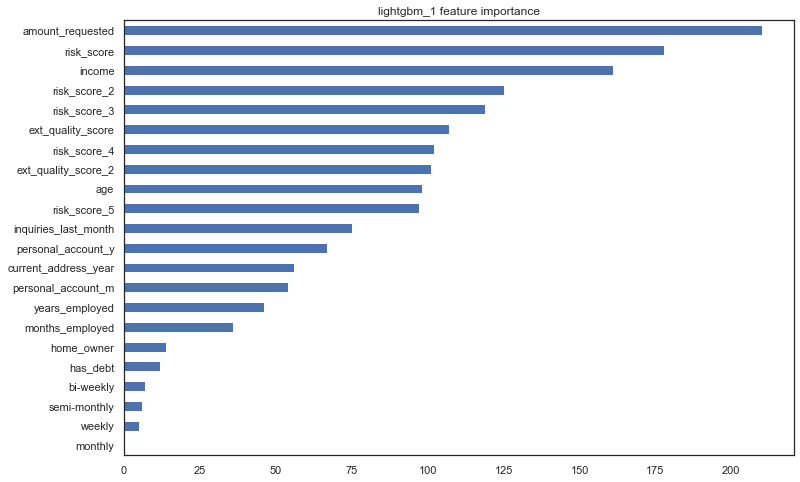

In [66]:
plt.figure(figsize=(12,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh',title='lightgbm_1 feature importance');

model_2:

In [67]:
xgb_clf = XGBClassifier(colsample_bytree=0.6682960151866543, gamma=1.0798626152988356e-08,
              learning_rate=0.02320865571556698, max_depth=6,
              min_child_weight=3, n_estimators=196,
              reg_alpha=0.060016599138875734, reg_lambda=3.429258701297801e-05,
              subsample=0.5054109001304139)

In [68]:
def xgb_predict(estimator, train, label, test, estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train)))
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index], train.iloc[test_index]
        y_train,y_test = label.iloc[train_index], label.iloc[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        
        estimator.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100,
                     early_stopping_rounds=200 
                     )
                     
        
        train_predict = estimator.predict_proba(x_train)[:, 1]
        test_predict = estimator.predict_proba(x_test)[:, 1]
        val_pred[test_index] = (test_predict)
        f_test= estimator.predict_proba(test)[:, 1]
        test_pred.append(f_test)
    
        print('\nValidation scores', roc_auc_score(y_test, test_predict))
        print('\nTraining scores', roc_auc_score(y_train, train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing AUC_score score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training AUC_score score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [69]:
xgb_train, xgb_test, xgb_estimator = xgb_predict(xgb_clf, X, y, test_copy, 'xgb_clf')

========================Fold1==========================
[0]	validation_0-logloss:0.69099	validation_1-logloss:0.69143
[100]	validation_0-logloss:0.60411	validation_1-logloss:0.64130
[195]	validation_0-logloss:0.56846	validation_1-logloss:0.63094

Validation scores 0.6972628604457003

Training scores 0.8210335895171701
========================Fold2==========================
[0]	validation_0-logloss:0.69115	validation_1-logloss:0.69138
[100]	validation_0-logloss:0.60376	validation_1-logloss:0.63566
[195]	validation_0-logloss:0.56676	validation_1-logloss:0.62794

Validation scores 0.692466765140325

Training scores 0.8253271798435922
========================Fold3==========================
[0]	validation_0-logloss:0.69119	validation_1-logloss:0.69152
[100]	validation_0-logloss:0.60084	validation_1-logloss:0.63842
[195]	validation_0-logloss:0.56558	validation_1-logloss:0.62824

Validation scores 0.6855898786205125

Training scores 0.8228674817898436
========================Fold4============

In [70]:
xgb_test_ = np.mean(xgb_test, axis=0)

model_3:

In [71]:
xgb_2 = XGBClassifier()
xgb_2.set_params(**{'max_depth': 8,
 'learning_rate': 0.03097330142137865,
 'n_estimators': 499,
 'min_child_weight': 3,
 'gamma': 0.00014108851650059825,
 'subsample': 0.9231145138691651,
 'colsample_bytree': 0.9670536338693626,
 'reg_alpha': 0.00011310709950064508,
 'reg_lambda': 1.2597877821986132e-08})

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9670536338693626, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.00014108851650059825, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03097330142137865, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=499, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=0.00011310709950064508,
              reg_lambda=1.2597877821986132e-08, ...)

In [72]:
xgb_2_train, xgb_2_test, xgb_2_estimator = xgb_predict(xgb_2, X, y, test_copy, 'xgb_clf_2')

========================Fold1==========================
[0]	validation_0-logloss:0.68923	validation_1-logloss:0.69038
[100]	validation_0-logloss:0.52919	validation_1-logloss:0.62294
[200]	validation_0-logloss:0.45887	validation_1-logloss:0.61575
[300]	validation_0-logloss:0.40953	validation_1-logloss:0.61404
[400]	validation_0-logloss:0.36457	validation_1-logloss:0.61301
[498]	validation_0-logloss:0.32806	validation_1-logloss:0.61516

Validation scores 0.7182762828334724

Training scores 0.9888849219666731
========================Fold2==========================
[0]	validation_0-logloss:0.68897	validation_1-logloss:0.69029
[100]	validation_0-logloss:0.52761	validation_1-logloss:0.61902
[200]	validation_0-logloss:0.46309	validation_1-logloss:0.61631
[300]	validation_0-logloss:0.41278	validation_1-logloss:0.61918
[400]	validation_0-logloss:0.36929	validation_1-logloss:0.62171

Validation scores 0.7003789095112709

Training scores 0.9385252728647446
========================Fold3===========

In [73]:
xgb_2_test = np.mean(xgb_2_test, axis=0)

In [74]:
# preparing model results for ensembling:
xgb_train = pd.DataFrame(xgb_train)
xgb_2_train = pd.DataFrame(xgb_2_train)
lgb_train = pd.DataFrame(lgb_train)
# ---------------------------------------
stack_train = pd.concat((xgb_train, xgb_2_train, lgb_train), axis=1)
stack_train.head()

0         0         0
0  0.576665  0.565816  0.737682
1  0.427056  0.427855  0.206949
2  0.700967  0.700313  0.650142
3  0.585420  0.558738  0.454794
4  0.556723  0.482709  0.451343

In [75]:
xgb_test_ = pd.DataFrame(xgb_test_)
xgb_2_test = pd.DataFrame(xgb_2_test)
lgb_test_ = pd.DataFrame(lgb_test_)
# -----------------------------------
stack_test = pd.concat((xgb_test_, xgb_2_test, lgb_test_), axis=1)
stack_test.head()

0         0         0
0  0.360520  0.308466  0.333925
1  0.720678  0.840729  0.776093
2  0.530376  0.587887  0.517935
3  0.571721  0.576584  0.611566
4  0.393138  0.332143  0.255641

In [76]:
# using Linear Regression as the first meta model 
lr = LinearRegression()
lr.fit(stack_train, y)

pred = lr.predict(stack_train)
pred

array([0.62509204, 0.36670404, 0.70218927, ..., 0.44126959, 0.53779044,
       0.65739997])

In [77]:
print(roc_auc_score(y, pred))

0.7081958128237094


In [78]:
# using Logistic Regression as the second meta model:
lg = LogisticRegression()
lg.fit(stack_train,y)

lg_pred = lg.predict_proba(stack_train)

In [79]:
print(roc_auc_score(y, lg_pred[:,1]))

0.708093948000874


In [80]:
# on stack test;

pred = lr.predict(stack_test)

pred_lg = lg.predict_proba(stack_test)[:,1]

#### preparing for submission:`

In [81]:
stack_submission_dict = {
    'Entry_id': test_entry_Id,
    'e_signed' : pred_lg #logisticRegression meta model performed better on LB
}

In [82]:
stack_submission = pd.DataFrame(stack_submission_dict)
#stack_submission.to_csv('stacked_models_lg.csv',index=False)